In [3]:

import requests
from urllib.parse import urlparse, quote
import urllib.request
import os
import pypdf
from collections import deque
import io
import re
from html.parser import HTMLParser
from qdrant_client import QdrantClient
import pandas as pd
from dotenv import load_dotenv
load_dotenv()
import uuid
from qdrant_client import models
from langchain.vectorstores.qdrant import Qdrant
from qdrant_client.models import Distance, VectorParams
from httpx import Timeout
from langchain.prompts import PromptTemplate
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain.chains import create_retrieval_chain
import google.generativeai as genai
from langchain_google_genai import GoogleGenerativeAIEmbeddings
from trafilatura import fetch_url, extract, html2txt, fetch_response
import asyncio
import aiohttp
import urllib
from urllib.parse import urlparse, quote, parse_qs
from html.parser import HTMLParser
from collections import deque
import re
import io
import os
import pypdf
import requests
from datetime import datetime


To crawl the webpage, I made use of the code mentioned in the OpenAI cookbook: https://github.com/openai/openai-cookbook/blob/main/apps/web-crawl-q-and-a/web-qa.ipynb?ref=mlq.ai

# RAG Implementation Comparison: Custom vs. LangChain

## Overview

In this notebook, I've implemented two versions of Retrieval-Augmented Generation (RAG):

1. A custom implementation built from scratch
2. An implementation using LangChain

## Key Findings

### Custom Implementation
- Built entirely from scratch
- Offers more control over the process
- Resulted in a more manageable size for Lambda deployment

### LangChain Implementation
- Utilized the LangChain library for RAG
- Provided pre-built components and easier setup
- Resulted in significantly larger deployment size

## Deployment Challenges

When attempting to deploy these implementations to AWS Lambda, I encountered notable differences:

- **Custom Implementation**: Successfully deployed within Lambda's size limits
- **LangChain Implementation**: Faced size-related errors during deployment

### Note on Multiple Layers
While I'm aware of the possibility of using multiple layers in Lambda to accommodate larger dependencies, this approach provided minimal improvements for the LangChain implementation. The size reduction was not significant enough to justify the added complexity of managing multiple layers.

## Conclusion

For my use case, the custom RAG implementation proved more suitable for Lambda deployment due to its smaller size footprint. While LangChain offers convenience and pre-built components, its size makes it challenging to deploy in serverless environments like Lambda without significant compromises.

The trade-off between development ease (LangChain) and deployment simplicity (custom implementation) is evident. For Lambda-based deployments, the custom approach appears to be more practical and cost-effective in the long run.

In [11]:
from trafilatura import fetch_url, extract, html2txt, fetch_response
import asyncio
import aiohttp
from urllib.error import HTTPError, URLError
import urllib.request
from urllib.parse import urlparse, quote, parse_qs
from html.parser import HTMLParser
from collections import deque
import re
import io
import os
import pypdf
import requests
from datetime import datetime

HTTP_URL_PATTERN = r'^http[s]*://.+'

# Parser to extract hyperlinks from HTML
class HyperlinkParser(HTMLParser):
    def __init__(self):
        super().__init__()
        self.hyperlinks = []

    def handle_starttag(self, tag, attrs):
        attrs = dict(attrs)
        if tag == "a" and "href" in attrs:
            self.hyperlinks.append(attrs["href"])

# Asynchronously fetch hyperlinks from a URL
def get_hyperlinks(url, headers=None):
    try:
        # Create a request object with custom headers
        request = urllib.request.Request(
            url,
            headers={
                'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36',
                'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8',
                'Accept-Language': 'en-US,en;q=0.5',
                **(headers or {})
            }
        )

        with urllib.request.urlopen(request) as response:
            if not response.info().get('Content-Type', '').startswith("text/html"):
                return []
            
            html = response.read().decode('utf-8')
            parser = HyperlinkParser()
            parser.feed(html)
            return parser.hyperlinks

    except HTTPError as e:
        print(f"HTTP Error for {url}: {e.code} - {e.reason}")
        return []
    except URLError as e:
        print(f"URL Error for {url}: {e.reason}")
        return []
    except Exception as e:
        print(f"Error processing {url}: {str(e)}")
        return []
    
#get the domain hyperlinks    
def get_domain_hyperlinks(local_domain, url, headers = None):
    clean_links = []
    for link in set(get_hyperlinks(url, headers)):
        clean_link = None
        
        if re.search(HTTP_URL_PATTERN, link):
            url_obj = urlparse(link)
            if url_obj.netloc == local_domain:
                clean_link = link
        else:
            if link.startswith('/'):
                link = link[1:]
            elif link.startswith(('#', "mailto", "form", "tel:", "javascript")):
                continue
            clean_link = f"https://{local_domain}/{link}"
        
        if clean_link:
            if clean_link.endswith("/"):
                clean_link = clean_link[:-1]
            clean_links.append(clean_link)
    
    return list(set(clean_links)) 

#write a function to deal with pdf files
def pdf_to_text(pdf_content):
    try:
        #create a file like object from the input PDF bytes/ this is to facilitate working with the PDF without saving to disk
        pdf_file = io.BytesIO(pdf_content)
        pdf_reader = pypdf.PdfReader(pdf_file)
        text = []
        for page in pdf_reader.pages:
            text.append(page.extract_text())
        return "\n\n---Page Break ---\n\n".join(text)
    except Exception as e:
        print(f"Error processing PDF: {str(e)}")
        return ""

def should_disregard_url(url, min_date_str): 
    social_media_domains = [ 
        "facebook.com", "twitter.com", "instagram.com",  
        "linkedin.com", "youtube.com", "pinterest.com" 
    ] 
     
    try: 
        min_date = datetime.strptime(min_date_str, "%Y-%m-%d").date() 
    except Exception as e: 
        print(f"Error parsing min_date_str: {e}") 
        return True 
     
    parsed = urlparse(url) 
     
    if "webcal:" in url: 
        return True 
     
    if "whatsapp" in url: 
        return True 
     
    for domain in social_media_domains: 
        if domain in parsed.netloc: 
            return True 
         
    if "zoom" in url.lower(): 
        return True 
     
    query_params = parse_qs(parsed.query) 
     
    if "tribe-bar-date" in query_params:  
        date_str = query_params["tribe-bar-date"][0] 
        try: 
            url_date = datetime.strptime(date_str, "%Y-%m-%d").date() 
            if url_date < min_date: 
                return True
        except Exception as e: 
            print(f"Error parsing tribe_bar_date from {url} : {e}") 
            return True 
            
    return False

def crawl_and_save_url(url):
    try:
        # Parse the URL to ensure proper directory creation
        parsed_url = urlparse(url)
        domain = parsed_url.netloc
        
        # Create directory structure
        save_dir = os.path.join('newtext', domain)
        os.makedirs(save_dir, exist_ok=True)
        
        # Sanitize filename
        sanitized_filename = quote(url, safe='') + '.txt'
        file_path = os.path.join(save_dir, sanitized_filename)
        
        # Fetch the response
        response = requests.get(url, timeout=10)
        
        # Open file for writing
        with open(file_path, "w", encoding='utf-8') as f:
            # Check if it's a PDF
            if response.headers.get('Content-Type') == "application/pdf":
                pdf_text = pdf_to_text(response.content)
                f.write(pdf_text)
            else:
                # Use trafilatura for web content extraction
                downloaded = fetch_url(url)
                result = extract(downloaded, favor_precision=True, with_metadata=True)
                f.write(result or "No content extracted")
        
        print(f"Successfully scraped and saved: {url}")
        return True
    
    except Exception as e:
        print(f"Error processing {url}: {str(e)}")
        return False

def crawl_website(url, min_date_str, max_pages=None):
    local_domain = urlparse(url).netloc
    queue = deque([url])
    seen = set([url])
    pages_crawled = 0
    pages_scraped = 0
    
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36',
        'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8',
        'Accept-Language': 'en-US,en;q=0.5',
    }
    
    print("Starting crawl...")
    
    # Scrape the initial URL
    if not should_disregard_url(url, min_date_str):
        if crawl_and_save_url(url):
            pages_scraped += 1
            
    while queue and (max_pages is None or pages_crawled < max_pages):
        current_url = queue.pop()
        pages_crawled += 1
        print(f"Processing: {current_url} (Page {pages_crawled})")
        
        try:
            # Get links from the current page
            for link in get_domain_hyperlinks(local_domain, current_url, headers):
                if link not in seen:
                    seen.add(link)
                    
                    # Check if the link should be disregarded
                    if not should_disregard_url(link, min_date_str):
                        # Immediately crawl and save the page
                        if crawl_and_save_url(link):
                            pages_scraped += 1
                        
                        # Add to queue for finding more links
                        queue.append(link)
                        
        except Exception as e:
            print(f"Error processing links from {current_url}: {str(e)}")
            continue
            
    print(f"Crawl finished. Total pages crawled: {pages_crawled}, Total pages scraped: {pages_scraped}")
    return pages_scraped

# Main execution
min_date = "2025-01-01"
url = 'https://www.ashoka.edu.in/'
max_pages = None  

# Run the crawler with immediate scraping
crawl_website(url, min_date, max_pages)

Starting crawl...
Successfully scraped and saved: https://www.ashoka.edu.in/
Processing: https://www.ashoka.edu.in/ (Page 1)
Successfully scraped and saved: https://www.ashoka.edu.in/department/department-of-media-studies
Successfully scraped and saved: https://www.ashoka.edu.in/ashoka-university-inks-mou-with-axis-bank-to-strengthen-interdisciplinary-sciences-research-excellence-axis-bank-commits-inr-104-crores-for-the-initiative
Successfully scraped and saved: https://www.ashoka.edu.in/roles/founders/?filterby=2197
Successfully scraped and saved: https://www.ashoka.edu.in/beyond-calories-the-impact-of-macronutrient-composition-on-life-history-and-ageing
Successfully scraped and saved: https://www.ashoka.edu.in/trivedi-school-of-biosciences
Successfully scraped and saved: https://www.ashoka.edu.in/department/department-of-cs
Successfully scraped and saved: https://www.ashoka.edu.in/research/the-politics-of-the-paycheck-protection-program
Successfully scraped and saved: https://www.ash

Successfully scraped and saved: https://www.ashoka.edu.in/research-listing
Successfully scraped and saved: https://www.ashoka.edu.in/academic-programme/summer-progammes
Successfully scraped and saved: https://www.ashoka.edu.in/admissions/financial-aid
Successfully scraped and saved: https://www.ashoka.edu.in/research/attributes-less-or-more
Successfully scraped and saved: https://www.ashoka.edu.in/wp-content/uploads/2025/02/Ashoka-Alumni-Vol.-II-1.pdf
Successfully scraped and saved: https://www.ashoka.edu.in/event/navigating-strategy-policy-money-the-global-commerce-learning-circle
Successfully scraped and saved: https://www.ashoka.edu.in/department/department-of-performing-arts
Successfully scraped and saved: https://www.ashoka.edu.in/programme/phd-programme-in-psychology
Successfully scraped and saved: https://www.ashoka.edu.in/programme/msc-program-biology
Successfully scraped and saved: https://www.ashoka.edu.in/science-advisory-council
Successfully scraped and saved: https://www.a

Successfully scraped and saved: https://www.ashoka.edu.in/roles/founders/?filterby=2195
Successfully scraped and saved: https://www.ashoka.edu.in/story/alumni-writes
Successfully scraped and saved: https://www.ashoka.edu.in/yif
Successfully scraped and saved: https://www.ashoka.edu.in/department/department-of-sociology-anthropology
Successfully scraped and saved: https://www.ashoka.edu.in/resources/#annualreports
Successfully scraped and saved: https://www.ashoka.edu.in/privacy-policy
Successfully scraped and saved: https://www.ashoka.edu.in/governing-body
Successfully scraped and saved: https://www.ashoka.edu.in/roles/founders/?filterby=2194
Successfully scraped and saved: https://www.ashoka.edu.in/roles/founders/?filterby=2196
Successfully scraped and saved: https://www.ashoka.edu.in/graduate-economics-placements
Successfully scraped and saved: https://www.ashoka.edu.in/placements/?page_y=placement-brouchure
Successfully scraped and saved: https://www.ashoka.edu.in/school-of-economic

ERROR:trafilatura.downloads:not a 200 response: 404 for URL https://www.ashoka.edu.in/news.php


Successfully scraped and saved: https://www.ashoka.edu.in/news.php
Successfully scraped and saved: https://www.ashoka.edu.in/department/department-of-history
Successfully scraped and saved: https://www.ashoka.edu.in/page/office-of-learning-support
Successfully scraped and saved: https://www.ashoka.edu.in/research/cheap-talk-with-multiple-senders-and-receivers-information-transmission-in-ethnic-conflicts
Successfully scraped and saved: https://www.ashoka.edu.in/programme/phd-programme-in-chemistry
Successfully scraped and saved: https://www.ashoka.edu.in/resources/#internalqualityassurancecell(iqac)
Successfully scraped and saved: https://www.ashoka.edu.in/department/department-of-environmental-studies
Successfully scraped and saved: https://www.ashoka.edu.in/student-affairs
Successfully scraped and saved: https://www.ashoka.edu.in/academic-programme/lodha-genius-programme
Successfully scraped and saved: https://www.ashoka.edu.in/admissions/master-of-arts-in-english
Successfully scraped

Successfully scraped and saved: https://www.ashoka.edu.in/academic-calendar
Successfully scraped and saved: https://www.ashoka.edu.in/student-government
Successfully scraped and saved: https://www.ashoka.edu.in/page/centre-for-data-learning-and-decision-sciences-cdlds
Successfully scraped and saved: https://www.ashoka.edu.in/about-us
Successfully scraped and saved: https://www.ashoka.edu.in/department/department-of-philosophy
Successfully scraped and saved: https://www.ashoka.edu.in/office-of-the-dean-of-faculty-2
Successfully scraped and saved: https://www.ashoka.edu.in/department/department-of-physics


Successfully scraped and saved: https://www.ashoka.edu.in/roles/faculty/?yearby=all&filterby=21
Successfully scraped and saved: https://www.ashoka.edu.in/admissions/ph-d-in-the-physics-department
Successfully scraped and saved: https://www.ashoka.edu.in/contact-us
Successfully scraped and saved: https://www.ashoka.edu.in/event/learning-circle-brain-body-the-universe
Successfully scraped and saved: https://www.ashoka.edu.in/resources/#importantresources
Successfully scraped and saved: https://www.ashoka.edu.in/sustainability-at-ashoka
Successfully scraped and saved: https://www.ashoka.edu.in/young-india-fellowship-placements
Successfully scraped and saved: https://www.ashoka.edu.in/research-and-development-office
Successfully scraped and saved: https://www.ashoka.edu.in/sisters-shaping-futures-exploring-the-impact-of-mary-wards-vision-on-girls-education-in-india
Successfully scraped and saved: https://www.ashoka.edu.in/roles/leadership-team/?filterby=320
Successfully scraped and saved: 

ERROR:trafilatura.downloads:pycurl error: https://www.ashoka.edu.in/research-listing/?_ashoka=economics-discussions-papers
 (3, 'URL rejected: Malformed input to a URL function')


Successfully scraped and saved: https://www.ashoka.edu.in/research-listing/?_ashoka=economics-discussions-papers

Successfully scraped and saved: https://www.ashoka.edu.in/department/department-of-mathematics
Successfully scraped and saved: https://www.ashoka.edu.in/programme/phd-programme-in-history
Successfully scraped and saved: https://www.ashoka.edu.in/wp-content/uploads/2024/10/Enquiry-Single-Page.pdf
Successfully scraped and saved: https://www.ashoka.edu.in/yif-2026-all-fellows-on-scholarships
Successfully scraped and saved: https://www.ashoka.edu.in/news-events
Successfully scraped and saved: https://www.ashoka.edu.in/centres/centres
Successfully scraped and saved: https://www.ashoka.edu.in/campus-facilities
Successfully scraped and saved: https://www.ashoka.edu.in/wp-content/uploads/2021/06/Ashoka-University-Brochure-1.pdf
Successfully scraped and saved: https://www.ashoka.edu.in/resources/#handbooksandbrochures


ERROR:trafilatura.downloads:not a 200 response: 404 for URL https://www.ashoka.edu.in/wp-content/uploads/2024/12/Public-Self-Disclosure.pdf


Successfully scraped and saved: https://www.ashoka.edu.in/wp-content/uploads/2024/12/Public-Self-Disclosure.pdf
Successfully scraped and saved: https://www.ashoka.edu.in
Successfully scraped and saved: https://www.ashoka.edu.in/axis-bank-post-doctoral-programme-ashoka
Successfully scraped and saved: https://www.ashoka.edu.in/events
Successfully scraped and saved: https://www.ashoka.edu.in/department/department-of-creative-writing
Successfully scraped and saved: https://www.ashoka.edu.in/research/agriculture-electrification-and-gendered-time-use-in-rural-bangladesh
Successfully scraped and saved: https://www.ashoka.edu.in/course-catalogue
Successfully scraped and saved: https://www.ashoka.edu.in/page/centre-for-interdisciplinary-archaeological-research
Successfully scraped and saved: https://www.ashoka.edu.in/department/department-of-economics
Successfully scraped and saved: https://www.ashoka.edu.in/reflections-nl
Successfully scraped and saved: https://www.ashoka.edu.in/story/research

Successfully scraped and saved: https://www.ashoka.edu.in/roles/faculty/?yearby=all&filterby=20
Successfully scraped and saved: https://www.ashoka.edu.in/alumni-ashoka
Successfully scraped and saved: https://www.ashoka.edu.in/admissions
Successfully scraped and saved: https://www.ashoka.edu.in/admissions/graduate-admissions
Successfully scraped and saved: https://www.ashoka.edu.in/applying-evolutionary-game-theory-to-understand-institutional-effectiveness
Successfully scraped and saved: https://www.ashoka.edu.in/campus-student-life
Successfully scraped and saved: https://www.ashoka.edu.in/admissions/undergraduate-international-students
Successfully scraped and saved: https://www.ashoka.edu.in/department/department-of-psychology
Successfully scraped and saved: https://www.ashoka.edu.in/wp-content/uploads/2023/03/Ashoka-Brochure-2023.pdf_compressed.pdf
Successfully scraped and saved: https://www.ashoka.edu.in/tag/research
Successfully scraped and saved: https://www.ashoka.edu.in/programm

Successfully scraped and saved: https://www.ashoka.edu.in/in-the-media
Successfully scraped and saved: https://www.ashoka.edu.in/tag/Student
Successfully scraped and saved: https://www.ashoka.edu.in/story/editors-pick
Successfully scraped and saved: https://www.ashoka.edu.in/department/department-of-biology
Successfully scraped and saved: https://www.ashoka.edu.in/ombudsperson
Successfully scraped and saved: https://www.ashoka.edu.in/academic-integrity-policy
Successfully scraped and saved: https://www.ashoka.edu.in/program/visiting-student-programme
Successfully scraped and saved: https://www.ashoka.edu.in/making-the-uncomfortable-comfortable
Successfully scraped and saved: https://www.ashoka.edu.in/home
Successfully scraped and saved: https://www.ashoka.edu.in/event/physics-colloquium
Successfully scraped and saved: https://www.ashoka.edu.in/remote-teaching-and-learning-handbook
Successfully scraped and saved: https://www.ashoka.edu.in/page/centre-for-china-studies
Successfully scrap

ERROR:trafilatura.downloads:not a 200 response: 404 for URL https://www.ashoka.edu.in/program/summer-study-abroad


Successfully scraped and saved: https://www.ashoka.edu.in/program/summer-study-abroad
Successfully scraped and saved: https://www.ashoka.edu.in/admission_courses/graduate-admissions


Successfully scraped and saved: https://www.ashoka.edu.in/roles/faculty/?yearby=all&filterby=1328
Successfully scraped and saved: https://www.ashoka.edu.in/academic_courses/ma-in-liberal-studies
Successfully scraped and saved: https://www.ashoka.edu.in/roles/faculty/?yearby=1350&filterby=19


Successfully scraped and saved: https://www.ashoka.edu.in/roles/faculty/?yearby=all
Successfully scraped and saved: https://www.ashoka.edu.in/academics_programme/phd
Successfully scraped and saved: https://www.ashoka.edu.in/academics_programme/undergraduate
Successfully scraped and saved: https://www.ashoka.edu.in/tag/student
Successfully scraped and saved: https://www.ashoka.edu.in/my-tryst-with-entrepreneurship-at-ashoka-nurturing-growth-empowering-futures
Successfully scraped and saved: https://www.ashoka.edu.in/entrepreneur-in-residence-program


ERROR:trafilatura.downloads:not a 200 response: 404 for URL https://www.ashoka.edu.in/admission_courses/young-india-fellowship-admission


Successfully scraped and saved: https://www.ashoka.edu.in/admission_courses/young-india-fellowship-admission
Successfully scraped and saved: https://www.ashoka.edu.in/academic_courses/ashoka-scholars-programme
Successfully scraped and saved: https://www.ashoka.edu.in/admission_courses/undergraduate-students


ERROR:trafilatura.downloads:not a 200 response: 404 for URL https://www.ashoka.edu.in/program/semester-aboard-program


Successfully scraped and saved: https://www.ashoka.edu.in/program/semester-aboard-program
Successfully scraped and saved: https://www.ashoka.edu.in/academics_programme/young-india-fellowship
Successfully scraped and saved: https://www.ashoka.edu.in/admission_courses/financial-aid
Processing: https://www.ashoka.edu.in/admission_courses/financial-aid (Page 3)


ERROR:trafilatura.utils:parsed tree length: 1, wrong data type or not valid HTML
ERROR:trafilatura.core:empty HTML tree: None


Successfully scraped and saved: https://www.ashoka.edu.in/wp-content/uploads/2021/05/Ashok-University-Dec24-1.png
Successfully scraped and saved: https://www.ashoka.edu.in/wp-content/uploads/2021/05/Ashoka-UniversityFlyer_compressed-4.pdf
Successfully scraped and saved: https://www.ashoka.edu.in/https-www-ashoka-edu-in-arunkumar-ramniklal-mehta-scholarship-arra
Successfully scraped and saved: https://www.ashoka.edu.in/undergraduate-programme-financial-aid
Successfully scraped and saved: https://www.ashoka.edu.in/ma-english-programme-2
Successfully scraped and saved: https://www.ashoka.edu.in/financial-aid-application-process#step1
Successfully scraped and saved: https://www.ashoka.edu.in/wp-content/uploads/2021/05/Financial-Aid-Sample-Form-1.pdf
Successfully scraped and saved: https://www.ashoka.edu.in/financial-aid-application-process#step4
Successfully scraped and saved: https://www.ashoka.edu.in/parent-testimonials
Successfully scraped and saved: https://www.ashoka.edu.in/ma-economi

ERROR:trafilatura.downloads:not a 200 response: 404 for URL https://www.ashoka.edu.in/wp-content/uploads/https://dp.ashoka.edu.in/ash/wpaper/paper513_1.pdf


Successfully scraped and saved: https://www.ashoka.edu.in/wp-content/uploads/https://dp.ashoka.edu.in/ash/wpaper/paper513_1.pdf
Successfully scraped and saved: https://www.ashoka.edu.in/undergraduate-international-students-financial-aid
Successfully scraped and saved: https://www.ashoka.edu.in/undergraduate-international-students-admissions-timeline
Successfully scraped and saved: https://www.ashoka.edu.in/undergraduate-international-admissions-process-key-policies
Processing: https://www.ashoka.edu.in/undergraduate-international-admissions-process-key-policies (Page 47)
Processing: https://www.ashoka.edu.in/undergraduate-international-students-admissions-timeline (Page 48)
Processing: https://www.ashoka.edu.in/undergraduate-international-students-financial-aid (Page 49)
Processing: https://www.ashoka.edu.in/wp-content/uploads/https://dp.ashoka.edu.in/ash/wpaper/paper513_1.pdf (Page 50)
HTTP Error for https://www.ashoka.edu.in/wp-content/uploads/https://dp.ashoka.edu.in/ash/wpaper/pape

ERROR:trafilatura.downloads:not a 200 response: 404 for URL https://www.ashoka.edu.in/page/connect-with-ashoka-12#/section-181


Successfully scraped and saved: https://www.ashoka.edu.in/page/connect-with-ashoka-12#/section-181
Successfully scraped and saved: https://www.ashoka.edu.in/profile/bittu-kaveri-rajaraman
Successfully scraped and saved: https://www.ashoka.edu.in/static/doc_uploads/file_1610451423.pdf
Successfully scraped and saved: https://www.ashoka.edu.in/profile/imroze-khan


ERROR:trafilatura.downloads:not a 200 response: 404 for URL https://www.ashoka.edu.in/page/ug-admissions-40


Successfully scraped and saved: https://www.ashoka.edu.in/page/ug-admissions-40


Successfully scraped and saved: https://www.ashoka.edu.in/static/doc_uploads/file_1563447935.pdf
Successfully scraped and saved: https://www.ashoka.edu.in/admission_courses/master-of-arts-in-economics
Processing: https://www.ashoka.edu.in/admission_courses/master-of-arts-in-economics (Page 83)


Successfully scraped and saved: https://www.ashoka.edu.in/roles/faculty/?filterby=20&yearby=30
Successfully scraped and saved: https://www.ashoka.edu.in/wp-content/uploads/2021/05/MA-Electives-1.pdf
Successfully scraped and saved: https://www.ashoka.edu.in/programme/master-of-arts-in-economics


Successfully scraped and saved: https://www.ashoka.edu.in/research-listing/?_ashoka=economics-discussions-papers


Successfully scraped and saved: https://www.ashoka.edu.in/roles/phd-candidates/?filterby=economics


Successfully scraped and saved: https://www.ashoka.edu.in/roles/faculty/?yearby=30&filterby=21
Successfully scraped and saved: https://www.ashoka.edu.in/econphdjmc
Successfully scraped and saved: https://www.ashoka.edu.in/programme/undergraduate-in-economics-2
Successfully scraped and saved: https://www.ashoka.edu.in/programme/ashoka-scholars-programme-economics-2
Processing: https://www.ashoka.edu.in/programme/ashoka-scholars-programme-economics-2 (Page 84)
Successfully scraped and saved: https://www.ashoka.edu.in/the-ashoka-scholars-programme


Successfully scraped and saved: https://www.ashoka.edu.in/course_detail/economics-courses
Processing: https://www.ashoka.edu.in/course_detail/economics-courses (Page 85)
Successfully scraped and saved: https://www.ashoka.edu.in/academic_sub_courses/introduction-to-economics
Successfully scraped and saved: https://www.ashoka.edu.in/academic_sub_courses/game-theory-and-applications-2
Successfully scraped and saved: https://www.ashoka.edu.in/academic_sub_courses/financial-markets-and-asset-pricing
Successfully scraped and saved: https://www.ashoka.edu.in/academic_sub_courses/economics-of-agricultural-transformation
Successfully scraped and saved: https://www.ashoka.edu.in/academic_sub_courses/advanced-macroeconomics-2
Successfully scraped and saved: https://www.ashoka.edu.in/academic_sub_courses/behavioural-economics-2
Successfully scraped and saved: https://www.ashoka.edu.in/academic_sub_courses/math-camp
Successfully scraped and saved: https://www.ashoka.edu.in/academic_sub_courses/stat

ERROR:trafilatura.downloads:pycurl error: https://www.ashoka.edu.in/academic_sub_courses/firm-and-sectoral-dynamics (47, 'Maximum (2) redirects followed')


Successfully scraped and saved: https://www.ashoka.edu.in/academic_sub_courses/firm-and-sectoral-dynamics
Successfully scraped and saved: https://www.ashoka.edu.in/academic_sub_courses/microeconomic-theory-i-2
Successfully scraped and saved: https://www.ashoka.edu.in/academic_sub_courses/the-indian-economy
Successfully scraped and saved: https://www.ashoka.edu.in/academic_sub_courses/public-economics-3
Successfully scraped and saved: https://www.ashoka.edu.in/academic_sub_courses/economics-of-information-2
Successfully scraped and saved: https://www.ashoka.edu.in/academic_sub_courses/economics-of-discrimination
Successfully scraped and saved: https://www.ashoka.edu.in/academic_sub_courses/advanced-macroeconomics
Successfully scraped and saved: https://www.ashoka.edu.in/academic_sub_courses/axiomatic-methods-fair-division-problems-and-welfare-economics-2
Successfully scraped and saved: https://www.ashoka.edu.in/academic_sub_courses/econometrics-2
Successfully scraped and saved: https://

Successfully scraped and saved: https://www.ashoka.edu.in/roles/faculty/?yearby=35
Successfully scraped and saved: https://www.ashoka.edu.in/mathematics-colloquium


Successfully scraped and saved: https://www.ashoka.edu.in/roles/phd-candidates/?filterby=mathematics
Successfully scraped and saved: https://www.ashoka.edu.in/academic_sub_courses/mathematics-and-computer-science/?pid=132&cid=
Successfully scraped and saved: https://www.ashoka.edu.in/programme/undergraduate-programme-in-mathematics
Successfully scraped and saved: https://www.ashoka.edu.in/wp-content/uploads/2021/06/Mathematics_Handbook_Ashoka-2.pdf
Successfully scraped and saved: https://www.ashoka.edu.in/wp-content/uploads/2023/10/Mathematics_Handbook_Ashoka-14.pdf
Successfully scraped and saved: https://www.ashoka.edu.in/course_detail/mathematics-courses
Processing: https://www.ashoka.edu.in/course_detail/mathematics-courses (Page 89)
Successfully scraped and saved: https://www.ashoka.edu.in/academic_sub_courses/mat-2003-real-analysis
Successfully scraped and saved: https://www.ashoka.edu.in/academic_sub_courses/mat-2002-algebra-2
Successfully scraped and saved: https://www.ashoka.ed

ERROR:trafilatura.utils:parsed tree length: 0, wrong data type or not valid HTML
ERROR:trafilatura.core:empty HTML tree: None


Successfully scraped and saved: https://www.ashoka.edu.in/media-maths/img-5365


ERROR:trafilatura.utils:parsed tree length: 0, wrong data type or not valid HTML
ERROR:trafilatura.core:empty HTML tree: None


Successfully scraped and saved: https://www.ashoka.edu.in/media-maths/img-6168


ERROR:trafilatura.utils:parsed tree length: 0, wrong data type or not valid HTML
ERROR:trafilatura.core:empty HTML tree: None


Successfully scraped and saved: https://www.ashoka.edu.in/media-maths/img-6647


ERROR:trafilatura.utils:parsed tree length: 0, wrong data type or not valid HTML
ERROR:trafilatura.core:empty HTML tree: None


Successfully scraped and saved: https://www.ashoka.edu.in/media-maths/img-6644


ERROR:trafilatura.utils:parsed tree length: 0, wrong data type or not valid HTML
ERROR:trafilatura.core:empty HTML tree: None


Successfully scraped and saved: https://www.ashoka.edu.in/media-maths/img-5361


ERROR:trafilatura.utils:parsed tree length: 0, wrong data type or not valid HTML
ERROR:trafilatura.core:empty HTML tree: None


Successfully scraped and saved: https://www.ashoka.edu.in/media-maths/img-6642


ERROR:trafilatura.utils:parsed tree length: 0, wrong data type or not valid HTML
ERROR:trafilatura.core:empty HTML tree: None


Successfully scraped and saved: https://www.ashoka.edu.in/media-maths/img-6641
Processing: https://www.ashoka.edu.in/media-maths/img-6641 (Page 118)
Processing: https://www.ashoka.edu.in/media-maths/img-6642 (Page 119)
Processing: https://www.ashoka.edu.in/media-maths/img-5361 (Page 120)
Processing: https://www.ashoka.edu.in/media-maths/img-6644 (Page 121)
Processing: https://www.ashoka.edu.in/media-maths/img-6647 (Page 122)
Processing: https://www.ashoka.edu.in/media-maths/img-6168 (Page 123)
Processing: https://www.ashoka.edu.in/media-maths/img-5365 (Page 124)
Processing: https://www.ashoka.edu.in/roles/faculty/?yearby=35 (Page 125)
Successfully scraped and saved: https://www.ashoka.edu.in/profile/krishna-maddaly
Successfully scraped and saved: https://www.ashoka.edu.in/profile/sourav-ghosh
Successfully scraped and saved: https://www.ashoka.edu.in/profile/pritam-ghosh
Successfully scraped and saved: https://www.ashoka.edu.in/profile/debapratim-banerjee
Successfully scraped and saved:

Successfully scraped and saved: https://www.ashoka.edu.in/roles/faculty/?yearby=28


Successfully scraped and saved: https://www.ashoka.edu.in/roles/phd-candidates/?filterby=computer-science
Successfully scraped and saved: https://www.ashoka.edu.in/courses/discrete-mathematics-2
Successfully scraped and saved: https://www.ashoka.edu.in/academic_sub_courses/introduction-to-computer-programming
Successfully scraped and saved: https://www.ashoka.edu.in/courses/design-practices-in-cs
Successfully scraped and saved: https://www.ashoka.edu.in/programme/graduate-assistantship-in-computer-science
Successfully scraped and saved: https://www.ashoka.edu.in/computer-science-advisors
Successfully scraped and saved: https://www.ashoka.edu.in/programme/ashoka-scholars-programme-in-computer-science
Successfully scraped and saved: https://www.ashoka.edu.in/courses/information-security
Successfully scraped and saved: https://www.ashoka.edu.in/programme/undergraduate-programme-in-computer-science
Processing: https://www.ashoka.edu.in/programme/undergraduate-programme-in-computer-science 

ERROR:trafilatura.downloads:not a 200 response: 404 for URL https://www.ashoka.edu.in/?post_type=profile&p=1324


Successfully scraped and saved: https://www.ashoka.edu.in/?post_type=profile&p=1324
Successfully scraped and saved: https://www.ashoka.edu.in/profile/sudheendra-hangal-2
Processing: https://www.ashoka.edu.in/profile/sudheendra-hangal-2 (Page 149)
Processing: https://www.ashoka.edu.in/?post_type=profile&p=1324 (Page 150)
HTTP Error for https://www.ashoka.edu.in/?post_type=profile&p=1324: 404 - Not Found
Processing: https://www.ashoka.edu.in/courses/discrete-mathematics-2 (Page 151)
Processing: https://www.ashoka.edu.in/roles/phd-candidates/?filterby=computer-science (Page 152)
Successfully scraped and saved: https://www.ashoka.edu.in/profile/adityavir-singh
Successfully scraped and saved: https://www.ashoka.edu.in/profile/tirna-ghosh-2
Successfully scraped and saved: https://www.ashoka.edu.in/profile/shubham-agarwal
Successfully scraped and saved: https://www.ashoka.edu.in/profile/chanda-grover
Successfully scraped and saved: https://www.ashoka.edu.in/profile/arup-mondal
Successfully sc

Successfully scraped and saved: https://www.ashoka.edu.in/faculty-research-2/?faculty_id=614&research_type=research_listing
Successfully scraped and saved: https://www.ashoka.edu.in/research/can-legal-bans-on-sex-detection-technology-reduce-gender-discrimination
Processing: https://www.ashoka.edu.in/research/can-legal-bans-on-sex-detection-technology-reduce-gender-discrimination (Page 214)
Successfully scraped and saved: https://www.ashoka.edu.in/research_topic/ultrasound
Successfully scraped and saved: https://www.ashoka.edu.in/research_topic/pndt
Successfully scraped and saved: https://www.ashoka.edu.in/research_topic/son-preference
Successfully scraped and saved: https://www.ashoka.edu.in/research_topic/sex-selective-abortion-missing-women
Successfully scraped and saved: https://www.ashoka.edu.in/research_topic/gender-discrimination
Successfully scraped and saved: https://www.ashoka.edu.in/research_topic/skewed-sex-ratio
Successfully scraped and saved: https://www.ashoka.edu.in/rese

ERROR:trafilatura.utils:parsed tree length: 1, wrong data type or not valid HTML
ERROR:trafilatura.core:empty HTML tree: None


Successfully scraped and saved: https://www.ashoka.edu.in/wp-content/uploads/2024/06/image8.jpg


ERROR:trafilatura.utils:parsed tree length: 1, wrong data type or not valid HTML
ERROR:trafilatura.core:empty HTML tree: None


Successfully scraped and saved: https://www.ashoka.edu.in/wp-content/uploads/2024/06/image24.jpg


ERROR:trafilatura.utils:parsed tree length: 1, wrong data type or not valid HTML
ERROR:trafilatura.core:empty HTML tree: None


Successfully scraped and saved: https://www.ashoka.edu.in/wp-content/uploads/2024/06/image22.jpg


ERROR:trafilatura.utils:parsed tree length: 1, wrong data type or not valid HTML
ERROR:trafilatura.core:empty HTML tree: None


Successfully scraped and saved: https://www.ashoka.edu.in/wp-content/uploads/2024/06/image2.jpg


ERROR:trafilatura.utils:parsed tree length: 1, wrong data type or not valid HTML
ERROR:trafilatura.core:empty HTML tree: None


Successfully scraped and saved: https://www.ashoka.edu.in/wp-content/uploads/2024/06/image13.jpg


ERROR:trafilatura.utils:parsed tree length: 1, wrong data type or not valid HTML
ERROR:trafilatura.core:empty HTML tree: None


Successfully scraped and saved: https://www.ashoka.edu.in/wp-content/uploads/2024/06/image28.jpg
Processing: https://www.ashoka.edu.in/wp-content/uploads/2024/06/image28.jpg (Page 342)
Processing: https://www.ashoka.edu.in/wp-content/uploads/2024/06/image13.jpg (Page 343)
Processing: https://www.ashoka.edu.in/wp-content/uploads/2024/06/image2.jpg (Page 344)
Processing: https://www.ashoka.edu.in/wp-content/uploads/2024/06/image22.jpg (Page 345)
Processing: https://www.ashoka.edu.in/wp-content/uploads/2024/06/image24.jpg (Page 346)
Processing: https://www.ashoka.edu.in/wp-content/uploads/2024/06/image8.jpg (Page 347)
Processing: https://www.ashoka.edu.in/myashokastory-embracing-change-and-excellence (Page 348)
Processing: https://www.ashoka.edu.in/beyond-the-experiment-navigating-molecular-landscapes-with-computational-chemistry (Page 349)
Processing: https://www.ashoka.edu.in/ashoka-universitys-commitment-to-the-environment-celebrating-world-environment-day (Page 350)
Processing: https:

ERROR:trafilatura.downloads:not a 200 response: 404 for URL https://www.ashoka.edu.in/C:\Users\sangeeta.krishnan\Downloads\doi.org\10.1111\csp2.13069


Successfully scraped and saved: https://www.ashoka.edu.in/C:\Users\sangeeta.krishnan\Downloads\doi.org\10.1111\csp2.13069
Processing: https://www.ashoka.edu.in/C:\Users\sangeeta.krishnan\Downloads\doi.org\10.1111\csp2.13069 (Page 388)
HTTP Error for https://www.ashoka.edu.in/C:\Users\sangeeta.krishnan\Downloads\doi.org\10.1111\csp2.13069: 404 - Not Found
Processing: https://www.ashoka.edu.in/beyond-the-horn-exploring-masculinity-and-self-discovery-in-childrens-literature (Page 389)
Processing: https://www.ashoka.edu.in/ashoka-university-student-wins-gold-at-para-swimming-nationals (Page 390)
Processing: https://www.ashoka.edu.in/gaining-perspective-a-harvard-graduates-journey-in-transforming-indian-higher-education (Page 391)
Processing: https://www.ashoka.edu.in/fellow-to-founder-coming-a-full-circle (Page 392)
Processing: https://www.ashoka.edu.in/get-ready-to-explore-ashoka-announces-exciting-student-exchange-opportunities-with-top-global-universities (Page 393)
Successfully scraped

ERROR:trafilatura.downloads:not a 200 response: 404 for URL https://www.ashoka.edu.in/page/undergraduate-academics-1


Successfully scraped and saved: https://www.ashoka.edu.in/page/undergraduate-academics-1
Processing: https://www.ashoka.edu.in/page/undergraduate-academics-1 (Page 408)
HTTP Error for https://www.ashoka.edu.in/page/undergraduate-academics-1: 404 - Not Found
Processing: https://www.ashoka.edu.in/prof-sanjeev-chatterjee-awarded-fulbright-nehru-award (Page 409)
Processing: https://www.ashoka.edu.in/faculty-research-2/?faculty_id=2746&research_type=post (Page 410)
Processing: https://www.ashoka.edu.in/life-after-the-fellowship-kshitij-gargs (Page 411)
Processing: https://www.ashoka.edu.in/profile/manvi-sharma (Page 412)
Successfully scraped and saved: https://www.ashoka.edu.in/faculty-research-2/?faculty_id=37505&research_type=post
Successfully scraped and saved: https://www.ashoka.edu.in/wp-content/uploads/2022/11/CV_Manvi_Sept2022.pdf
Processing: https://www.ashoka.edu.in/wp-content/uploads/2022/11/CV_Manvi_Sept2022.pdf (Page 413)
Processing: https://www.ashoka.edu.in/faculty-research-2/

Successfully scraped and saved: https://www.ashoka.edu.in/roles/phd-candidates/?filterby=biology
Successfully scraped and saved: https://www.ashoka.edu.in/profile/sanjeev-kumar
Successfully scraped and saved: https://www.ashoka.edu.in/summer-internship-in-modern-biology-and-bioinformatics
Successfully scraped and saved: https://www.ashoka.edu.in/programme/ashoka-scholars-programme-in-biology
Successfully scraped and saved: https://www.ashoka.edu.in/research-staff
Successfully scraped and saved: https://www.ashoka.edu.in/human-research-ethics-committee-hrec
Successfully scraped and saved: https://www.ashoka.edu.in/biology-advisors
Successfully scraped and saved: https://www.ashoka.edu.in/wp-content/uploads/2023/05/Web-content_List-of-Students_ASP.pdf
Successfully scraped and saved: https://www.ashoka.edu.in/collaborating-institutes-tsb
Successfully scraped and saved: https://www.ashoka.edu.in/programme/phd-programme-in-biology
Successfully scraped and saved: https://www.ashoka.edu.in/wp

Successfully scraped and saved: https://www.ashoka.edu.in/roles/faculty/?yearby=26
Successfully scraped and saved: https://www.ashoka.edu.in/irb


ERROR:trafilatura.downloads:not a 200 response: 404 for URL https://www.ashoka.edu.in/?post_type=profile&p=916


Successfully scraped and saved: https://www.ashoka.edu.in/?post_type=profile&p=916
Successfully scraped and saved: https://www.ashoka.edu.in/institutional-biosafety-committee-ibsc
Successfully scraped and saved: https://www.ashoka.edu.in/tsb-dengue
Successfully scraped and saved: https://www.ashoka.edu.in/profile/ashok-trivedi
Successfully scraped and saved: https://www.ashoka.edu.in/biology-publications
Successfully scraped and saved: https://www.ashoka.edu.in/awards-honors
Successfully scraped and saved: https://www.ashoka.edu.in/preventive-health-programme-php
Successfully scraped and saved: https://www.ashoka.edu.in/profile/naveen-kumar-bhatraju
Successfully scraped and saved: https://www.ashoka.edu.in/wp-content/uploads/2023/05/Web-content_List-of-Students_UG.pdf
Successfully scraped and saved: https://www.ashoka.edu.in/non-resident-faculty-trivedi-school-of-biosciences
Successfully scraped and saved: https://www.ashoka.edu.in/structure-and-plans-tsb
Successfully scraped and saved

Successfully scraped and saved: https://www.ashoka.edu.in/wp-content/uploads/2022/09/CV_2022_Kumar-Dilip.pdf
Processing: https://www.ashoka.edu.in/wp-content/uploads/2022/09/CV_2022_Kumar-Dilip.pdf (Page 488)
Processing: https://www.ashoka.edu.in/tsb-staff (Page 489)
Successfully scraped and saved: https://www.ashoka.edu.in/profile/papri-banerjee
Successfully scraped and saved: https://www.ashoka.edu.in/profile/vinita-toma
Successfully scraped and saved: https://www.ashoka.edu.in/profile/vikas-chopra
Successfully scraped and saved: https://www.ashoka.edu.in/profile/nibedita
Successfully scraped and saved: https://www.ashoka.edu.in/profile/aradhita-baral
Successfully scraped and saved: https://www.ashoka.edu.in/profile/jitender-kumar-verma
Successfully scraped and saved: https://www.ashoka.edu.in/profile/abha-tiwari
Successfully scraped and saved: https://www.ashoka.edu.in/profile/ajay-malik-2
Successfully scraped and saved: https://www.ashoka.edu.in/profile/joy-bose
Successfully scrape

ERROR:trafilatura.downloads:not a 200 response: 404 for URL https://www.ashoka.edu.in/?post_type=profile&p=888


Successfully scraped and saved: https://www.ashoka.edu.in/?post_type=profile&p=888
Successfully scraped and saved: https://www.ashoka.edu.in/profile/bharat-ramaswami
Successfully scraped and saved: https://www.ashoka.edu.in/profile/kanika-mahajan
Successfully scraped and saved: https://www.ashoka.edu.in/profile/bhaskar-dutta
Successfully scraped and saved: https://www.ashoka.edu.in/profile/pratyay-nath
Successfully scraped and saved: https://www.ashoka.edu.in/profile/divya-karnad
Successfully scraped and saved: https://www.ashoka.edu.in/profile/shivani-krishna
Successfully scraped and saved: https://www.ashoka.edu.in/profile/sumana-roy
Successfully scraped and saved: https://www.ashoka.edu.in/profile/kritika-m-garg
Successfully scraped and saved: https://www.ashoka.edu.in/profile/tisha-srivastav
Processing: https://www.ashoka.edu.in/profile/tisha-srivastav (Page 529)


ERROR:trafilatura.downloads:not a 200 response: 404 for URL https://www.ashoka.edu.in/Users/tisha/Downloads/Recommedations%20to%20Draft%20NTP%202020%20FINAL%20SB.pdf


Successfully scraped and saved: https://www.ashoka.edu.in/Users/tisha/Downloads/Recommedations%20to%20Draft%20NTP%202020%20FINAL%20SB.pdf
Processing: https://www.ashoka.edu.in/Users/tisha/Downloads/Recommedations%20to%20Draft%20NTP%202020%20FINAL%20SB.pdf (Page 530)
HTTP Error for https://www.ashoka.edu.in/Users/tisha/Downloads/Recommedations%20to%20Draft%20NTP%202020%20FINAL%20SB.pdf: 404 - Not Found
Processing: https://www.ashoka.edu.in/profile/kritika-m-garg (Page 531)
Processing: https://www.ashoka.edu.in/profile/sumana-roy (Page 532)
Successfully scraped and saved: https://www.ashoka.edu.in/faculty-research-2/?faculty_id=1645&research_type=post
Successfully scraped and saved: https://www.ashoka.edu.in/cultivating-connections-the-indian-plant-humanities-project
Successfully scraped and saved: https://www.ashoka.edu.in/ashoka-university-congratulates-professor-sumana-roy-for-being-awarded-the-omega-resilience-awards-ora-fellowship-for-her-work-in-the-indian-plant-humanities
Successf

ERROR:trafilatura.downloads:not a 200 response: 404 for URL https://www.ashoka.edu.in/profile/kasturi-pal


Successfully scraped and saved: https://www.ashoka.edu.in/profile/kasturi-pal
Successfully scraped and saved: https://www.ashoka.edu.in/profile/sougata-roy
Processing: https://www.ashoka.edu.in/profile/sougata-roy (Page 601)
Processing: https://www.ashoka.edu.in/profile/kasturi-pal (Page 602)
HTTP Error for https://www.ashoka.edu.in/profile/kasturi-pal: 404 - Not Found
Processing: https://www.ashoka.edu.in/profile/krishna-melnattur (Page 603)
Successfully scraped and saved: https://www.ashoka.edu.in/faculty-research-2/?faculty_id=13310&research_type=post
Processing: https://www.ashoka.edu.in/faculty-research-2/?faculty_id=13310&research_type=post (Page 604)
Processing: https://www.ashoka.edu.in/biology-publications (Page 605)
Processing: https://www.ashoka.edu.in/profile/ashok-trivedi (Page 606)
Processing: https://www.ashoka.edu.in/tsb-dengue (Page 607)
Processing: https://www.ashoka.edu.in/institutional-biosafety-committee-ibsc (Page 608)
Processing: https://www.ashoka.edu.in/?post_t

Successfully scraped and saved: https://www.ashoka.edu.in/roles/faculty/page/2/?yearby=26
Successfully scraped and saved: https://www.ashoka.edu.in/profile/tanmoy-roychowdhury
Successfully scraped and saved: https://www.ashoka.edu.in/profile/alok-bhattacharya
Processing: https://www.ashoka.edu.in/profile/alok-bhattacharya (Page 612)
Successfully scraped and saved: https://www.ashoka.edu.in/in-the-media/indias-abandonment-of-families-living-with-a-childs-rare-disease
Successfully scraped and saved: https://www.ashoka.edu.in/faculty-research-2/?faculty_id=563&research_type=in-the-media
Processing: https://www.ashoka.edu.in/faculty-research-2/?faculty_id=563&research_type=in-the-media (Page 613)
Processing: https://www.ashoka.edu.in/in-the-media/indias-abandonment-of-families-living-with-a-childs-rare-disease (Page 614)
Processing: https://www.ashoka.edu.in/profile/tanmoy-roychowdhury (Page 615)
Processing: https://www.ashoka.edu.in/roles/faculty/page/2/?yearby=26 (Page 616)
Processing: h

ERROR:trafilatura.downloads:not a 200 response: 404 for URL https://www.ashoka.edu.in/?post_type=profile&p=47570


Successfully scraped and saved: https://www.ashoka.edu.in/?post_type=profile&p=47570
Successfully scraped and saved: https://www.ashoka.edu.in/profile/sushweta-mahalanobish
Successfully scraped and saved: https://www.ashoka.edu.in/profile/nilabhra-mitra
Successfully scraped and saved: https://www.ashoka.edu.in/profile/ankit-kumar
Successfully scraped and saved: https://www.ashoka.edu.in/profile/anindo-chatterjee
Successfully scraped and saved: https://www.ashoka.edu.in/profile/swati-agarwala
Successfully scraped and saved: https://www.ashoka.edu.in/profile/dipendra-nath-basu
Processing: https://www.ashoka.edu.in/profile/dipendra-nath-basu (Page 642)
Processing: https://www.ashoka.edu.in/profile/swati-agarwala (Page 643)
Processing: https://www.ashoka.edu.in/profile/anindo-chatterjee (Page 644)
Processing: https://www.ashoka.edu.in/profile/ankit-kumar (Page 645)
Processing: https://www.ashoka.edu.in/profile/nilabhra-mitra (Page 646)
Processing: https://www.ashoka.edu.in/profile/sushweta

Successfully scraped and saved: https://www.ashoka.edu.in/roles/phd-candidates/page/2/?filterby=biology
Successfully scraped and saved: https://www.ashoka.edu.in/profile/dinesh-balasaheb-jadhav
Successfully scraped and saved: https://www.ashoka.edu.in/profile/soham-chakraborty
Successfully scraped and saved: https://www.ashoka.edu.in/profile/kushal-banerjee
Successfully scraped and saved: https://www.ashoka.edu.in/profile/aarini-ghosh
Successfully scraped and saved: https://www.ashoka.edu.in/profile/kripanjali-ghosh
Successfully scraped and saved: https://www.ashoka.edu.in/profile/souradeep-banerjee
Successfully scraped and saved: https://www.ashoka.edu.in/profile/jishnu-borgohain
Successfully scraped and saved: https://www.ashoka.edu.in/profile/anandhu-j
Successfully scraped and saved: https://www.ashoka.edu.in/profile/bharti-golchha
Successfully scraped and saved: https://www.ashoka.edu.in/profile/durbadal-chatterjee
Successfully scraped and saved: https://www.ashoka.edu.in/profile/a

Successfully scraped and saved: https://www.ashoka.edu.in/roles/phd-candidates/page/3/?filterby=biology
Successfully scraped and saved: https://www.ashoka.edu.in/profile/nawaf-majeed
Successfully scraped and saved: https://www.ashoka.edu.in/profile/dhoopchhaya-sarkar
Successfully scraped and saved: https://www.ashoka.edu.in/profile/mayank-saini
Successfully scraped and saved: https://www.ashoka.edu.in/profile/chetan-s
Successfully scraped and saved: https://www.ashoka.edu.in/profile/kirnalee-patel
Successfully scraped and saved: https://www.ashoka.edu.in/profile/manan-mehta
Successfully scraped and saved: https://www.ashoka.edu.in/profile/diana-michael
Successfully scraped and saved: https://www.ashoka.edu.in/profile/muhammed-nirjas
Successfully scraped and saved: https://www.ashoka.edu.in/profile/saubhik-sarkar
Successfully scraped and saved: https://www.ashoka.edu.in/profile/kaushik-narayanan
Successfully scraped and saved: https://www.ashoka.edu.in/profile/rounak-saha
Successfully s

ERROR:trafilatura.utils:parsed tree length: 1, wrong data type or not valid HTML
ERROR:trafilatura.core:empty HTML tree: None


Successfully scraped and saved: https://www.ashoka.edu.in/page/centre-for-health-analytics-research-and-trends-chart/6-49
Successfully scraped and saved: https://www.ashoka.edu.in/coincide-project
Processing: https://www.ashoka.edu.in/coincide-project (Page 704)
Successfully scraped and saved: https://www.ashoka.edu.in/profile/siddhartha-mandal
Successfully scraped and saved: https://www.ashoka.edu.in/profile/aditi-roy
Successfully scraped and saved: https://www.ashoka.edu.in/profile/sonal-singh
Successfully scraped and saved: https://www.ashoka.edu.in/profile/shweta-dixit
Successfully scraped and saved: https://www.ashoka.edu.in/profile/jyothi-s-menon
Processing: https://www.ashoka.edu.in/profile/jyothi-s-menon (Page 705)
Processing: https://www.ashoka.edu.in/profile/shweta-dixit (Page 706)
Processing: https://www.ashoka.edu.in/profile/sonal-singh (Page 707)
Processing: https://www.ashoka.edu.in/profile/aditi-roy (Page 708)
Processing: https://www.ashoka.edu.in/profile/siddhartha-mand

Successfully scraped and saved: https://www.ashoka.edu.in/roles/yif-profiles/?filterby=2383
Successfully scraped and saved: https://www.ashoka.edu.in/yif-learning-and-engagement
Successfully scraped and saved: https://www.ashoka.edu.in/yif-critical-writing
Successfully scraped and saved: https://www.ashoka.edu.in/yif-experiential-learning-module
Successfully scraped and saved: https://www.ashoka.edu.in/?post_type=academics_programme&p=136
Successfully scraped and saved: https://www.ashoka.edu.in/yif-peer-learning
Successfully scraped and saved: https://www.ashoka.edu.in/yif-faqs-old
Successfully scraped and saved: https://www.ashoka.edu.in/yif-structure-and-design-2
Processing: https://www.ashoka.edu.in/yif-structure-and-design-2 (Page 809)


ERROR:trafilatura.downloads:not a 200 response: 404 for URL https://www.ashoka.edu.in/yif-alumni-in-residence


Successfully scraped and saved: https://www.ashoka.edu.in/yif-alumni-in-residence


ERROR:trafilatura.downloads:not a 200 response: 404 for URL https://www.ashoka.edu.in/the-yif-crossover-series


Successfully scraped and saved: https://www.ashoka.edu.in/the-yif-crossover-series
Successfully scraped and saved: https://www.ashoka.edu.in/yif-pathways
Successfully scraped and saved: https://www.ashoka.edu.in/yif-admissions
Processing: https://www.ashoka.edu.in/yif-admissions (Page 810)
Successfully scraped and saved: https://www.ashoka.edu.in/yif-faqs
Successfully scraped and saved: https://www.ashoka.edu.in/yif-scholarships-and-fee
Processing: https://www.ashoka.edu.in/yif-scholarships-and-fee (Page 811)
Successfully scraped and saved: https://www.ashoka.edu.in/static/doc_uploads/file_1610451497.pdf
Processing: https://www.ashoka.edu.in/static/doc_uploads/file_1610451497.pdf (Page 812)
Processing: https://www.ashoka.edu.in/yif-faqs (Page 813)


ERROR:trafilatura.downloads:not a 200 response: 404 for URL https://www.ashoka.edu.in/financial-aid-application-process-2


Successfully scraped and saved: https://www.ashoka.edu.in/financial-aid-application-process-2
Processing: https://www.ashoka.edu.in/financial-aid-application-process-2 (Page 814)
HTTP Error for https://www.ashoka.edu.in/financial-aid-application-process-2: 404 - Not Found
Processing: https://www.ashoka.edu.in/yif-pathways (Page 815)
Processing: https://www.ashoka.edu.in/the-yif-crossover-series (Page 816)
HTTP Error for https://www.ashoka.edu.in/the-yif-crossover-series: 404 - Not Found
Processing: https://www.ashoka.edu.in/yif-alumni-in-residence (Page 817)
HTTP Error for https://www.ashoka.edu.in/yif-alumni-in-residence: 404 - Not Found
Processing: https://www.ashoka.edu.in/yif-faqs-old (Page 818)
Processing: https://www.ashoka.edu.in/yif-peer-learning (Page 819)
Successfully scraped and saved: https://www.ashoka.edu.in/profile/nivvedhitha-shankar
Successfully scraped and saved: https://www.ashoka.edu.in/profile/manali-ravindra-ghodeswar
Successfully scraped and saved: https://www.as

Successfully scraped and saved: https://www.ashoka.edu.in/roles/yif-profiles/?filterby=2809
Successfully scraped and saved: https://www.ashoka.edu.in/profile/nene-onyedi-ibezim
Successfully scraped and saved: https://www.ashoka.edu.in/profile/janhavi-ghosalkar
Successfully scraped and saved: https://www.ashoka.edu.in/profile/sankalp-sharma
Successfully scraped and saved: https://www.ashoka.edu.in/profile/aparajitha-sankar
Successfully scraped and saved: https://www.ashoka.edu.in/profile/afshan-nisar
Successfully scraped and saved: https://www.ashoka.edu.in/profile/aboobacker-siddique-pk


Successfully scraped and saved: https://www.ashoka.edu.in/roles/yif-profiles/?filterby=3182
Successfully scraped and saved: https://www.ashoka.edu.in/profile/aryan-pandey
Successfully scraped and saved: https://www.ashoka.edu.in/profile/helena-fuluifaga-chan-foung
Successfully scraped and saved: https://www.ashoka.edu.in/profile/unmilan-kalita
Successfully scraped and saved: https://www.ashoka.edu.in/profile/meher-vadehra
Processing: https://www.ashoka.edu.in/profile/meher-vadehra (Page 820)
Processing: https://www.ashoka.edu.in/profile/unmilan-kalita (Page 821)
Processing: https://www.ashoka.edu.in/profile/helena-fuluifaga-chan-foung (Page 822)
Processing: https://www.ashoka.edu.in/profile/aryan-pandey (Page 823)
Processing: https://www.ashoka.edu.in/roles/yif-profiles/?filterby=3182 (Page 824)
Successfully scraped and saved: https://www.ashoka.edu.in/profile/kehkasha
Successfully scraped and saved: https://www.ashoka.edu.in/profile/praveen-a
Successfully scraped and saved: https://ww

Successfully scraped and saved: https://www.ashoka.edu.in/roles/yif-profiles/page/2/?filterby=3182
Successfully scraped and saved: https://www.ashoka.edu.in/profile/rutuja-chavan
Successfully scraped and saved: https://www.ashoka.edu.in/profile/kushagra-agarwal
Successfully scraped and saved: https://www.ashoka.edu.in/profile/geethanjali-g
Successfully scraped and saved: https://www.ashoka.edu.in/profile/ansuiya
Successfully scraped and saved: https://www.ashoka.edu.in/profile/samadhan-ambadas-galande
Successfully scraped and saved: https://www.ashoka.edu.in/profile/rusha-chatterjee
Successfully scraped and saved: https://www.ashoka.edu.in/profile/arushi-bhargava
Successfully scraped and saved: https://www.ashoka.edu.in/profile/serene-george
Successfully scraped and saved: https://www.ashoka.edu.in/profile/shruti-bhimrao-botare
Processing: https://www.ashoka.edu.in/profile/shruti-bhimrao-botare (Page 825)
Processing: https://www.ashoka.edu.in/profile/serene-george (Page 826)
Processing

Successfully scraped and saved: https://www.ashoka.edu.in/roles/yif-profiles/page/3/?filterby=3182
Successfully scraped and saved: https://www.ashoka.edu.in/profile/rishabh-jain-2
Successfully scraped and saved: https://www.ashoka.edu.in/profile/shweata-n-hegde
Successfully scraped and saved: https://www.ashoka.edu.in/profile/mumtaz-mohiuddin
Successfully scraped and saved: https://www.ashoka.edu.in/profile/anu-jakhar
Successfully scraped and saved: https://www.ashoka.edu.in/profile/sneha-mishra
Successfully scraped and saved: https://www.ashoka.edu.in/profile/gokul-govindan-nair
Successfully scraped and saved: https://www.ashoka.edu.in/profile/rohan-mathai-modayil
Successfully scraped and saved: https://www.ashoka.edu.in/profile/prashant-vilas-kumbhar
Successfully scraped and saved: https://www.ashoka.edu.in/profile/sohan-kundu
Successfully scraped and saved: https://www.ashoka.edu.in/profile/pratiksha-kalpraj
Processing: https://www.ashoka.edu.in/profile/pratiksha-kalpraj (Page 835)


Successfully scraped and saved: https://www.ashoka.edu.in/roles/yif-profiles/page/4/?filterby=3182
Successfully scraped and saved: https://www.ashoka.edu.in/profile/mahi-oberoi
Successfully scraped and saved: https://www.ashoka.edu.in/profile/zainab-saifee
Successfully scraped and saved: https://www.ashoka.edu.in/profile/tashi-sangdup
Successfully scraped and saved: https://www.ashoka.edu.in/profile/sobhana-pramod
Successfully scraped and saved: https://www.ashoka.edu.in/profile/anoushka-sharma
Successfully scraped and saved: https://www.ashoka.edu.in/profile/akash-sapkale
Successfully scraped and saved: https://www.ashoka.edu.in/profile/nikila-raman
Successfully scraped and saved: https://www.ashoka.edu.in/profile/pratiksha-prabhakar
Successfully scraped and saved: https://www.ashoka.edu.in/profile/damneet-sandhu
Processing: https://www.ashoka.edu.in/profile/damneet-sandhu (Page 846)
Processing: https://www.ashoka.edu.in/profile/pratiksha-prabhakar (Page 847)
Processing: https://www.a

Successfully scraped and saved: https://www.ashoka.edu.in/roles/yif-profiles/page/2/?filterby=2809
Successfully scraped and saved: https://www.ashoka.edu.in/profile/arunava-banerjee
Successfully scraped and saved: https://www.ashoka.edu.in/profile/murali-krishna-chidurala
Processing: https://www.ashoka.edu.in/profile/murali-krishna-chidurala (Page 889)
Processing: https://www.ashoka.edu.in/profile/arunava-banerjee (Page 890)
Processing: https://www.ashoka.edu.in/roles/yif-profiles/page/2/?filterby=2809 (Page 891)
Successfully scraped and saved: https://www.ashoka.edu.in/profile/nitin-jain
Successfully scraped and saved: https://www.ashoka.edu.in/profile/muntahar-ul-muzaffar


Successfully scraped and saved: https://www.ashoka.edu.in/roles/yif-profiles/page/3/?filterby=2809
Successfully scraped and saved: https://www.ashoka.edu.in/profile/sulagna-maitra
Successfully scraped and saved: https://www.ashoka.edu.in/profile/sangychetty-kumar
Successfully scraped and saved: https://www.ashoka.edu.in/profile/kanishk-hooda
Successfully scraped and saved: https://www.ashoka.edu.in/profile/jay-shailesh-ganatra
Successfully scraped and saved: https://www.ashoka.edu.in/profile/sai-motupali-nair
Successfully scraped and saved: https://www.ashoka.edu.in/profile/oviya-manivannan
Successfully scraped and saved: https://www.ashoka.edu.in/profile/madhuja-joshi
Successfully scraped and saved: https://www.ashoka.edu.in/profile/simran-kapoor
Successfully scraped and saved: https://www.ashoka.edu.in/profile/rohana-jeyaraj
Successfully scraped and saved: https://www.ashoka.edu.in/profile/sumira-grover
Successfully scraped and saved: https://www.ashoka.edu.in/profile/devanarayanan-m

Successfully scraped and saved: https://www.ashoka.edu.in/roles/yif-profiles/page/4/?filterby=2809
Successfully scraped and saved: https://www.ashoka.edu.in/profile/omiee-rastogi
Successfully scraped and saved: https://www.ashoka.edu.in/profile/manasi-prabhakaran
Successfully scraped and saved: https://www.ashoka.edu.in/profile/smriti-rawat
Successfully scraped and saved: https://www.ashoka.edu.in/profile/abhigyan-ray
Successfully scraped and saved: https://www.ashoka.edu.in/profile/balaji-chithra-ramakrishnan
Successfully scraped and saved: https://www.ashoka.edu.in/profile/dyuti-purohit
Successfully scraped and saved: https://www.ashoka.edu.in/profile/vasundhara-panghal
Successfully scraped and saved: https://www.ashoka.edu.in/profile/suhas-peela
Successfully scraped and saved: https://www.ashoka.edu.in/profile/vidya-rajagopalan
Processing: https://www.ashoka.edu.in/profile/vidya-rajagopalan (Page 908)
Processing: https://www.ashoka.edu.in/profile/suhas-peela (Page 909)
Processing: h

Successfully scraped and saved: https://www.ashoka.edu.in/roles/yif-profiles/page/5/?filterby=2809
Successfully scraped and saved: https://www.ashoka.edu.in/profile/shashank-v
Processing: https://www.ashoka.edu.in/profile/shashank-v (Page 918)
Processing: https://www.ashoka.edu.in/roles/yif-profiles/page/5/?filterby=2809 (Page 919)
Successfully scraped and saved: https://www.ashoka.edu.in/profile/pooja-yashodhare
Processing: https://www.ashoka.edu.in/profile/pooja-yashodhare (Page 920)
Processing: https://www.ashoka.edu.in/profile/rahul-uthale-2 (Page 921)
Processing: https://www.ashoka.edu.in/profile/pranav-sriram (Page 922)
Processing: https://www.ashoka.edu.in/profile/vaibhav-sharma (Page 923)
Processing: https://www.ashoka.edu.in/profile/sandra-sreekumar (Page 924)
Processing: https://www.ashoka.edu.in/profile/eisha-sathish-shetty-2 (Page 925)
Processing: https://www.ashoka.edu.in/profile/muskaan-saxena (Page 926)
Processing: https://www.ashoka.edu.in/profile/aroosh-singh (Page 927

ERROR:trafilatura.downloads:not a 200 response: 404 for URL https://www.ashoka.edu.in/yif-faqs-2


Successfully scraped and saved: https://www.ashoka.edu.in/yif-faqs-2
Successfully scraped and saved: https://www.ashoka.edu.in/hollywood-started-feeling-a-bit-like-home
Processing: https://www.ashoka.edu.in/hollywood-started-feeling-a-bit-like-home (Page 985)
Processing: https://www.ashoka.edu.in/yif-faqs-2 (Page 986)
HTTP Error for https://www.ashoka.edu.in/yif-faqs-2: 404 - Not Found
Processing: https://www.ashoka.edu.in/tag/yif-news (Page 987)
Processing: https://www.ashoka.edu.in/yif-experiential-learning-module (Page 988)
Processing: https://www.ashoka.edu.in/yif-critical-writing (Page 989)
Successfully scraped and saved: https://www.ashoka.edu.in/profile/ananya-dasgupta
Successfully scraped and saved: https://www.ashoka.edu.in/wp-content/uploads/2024/05/Cw-jounal-doc-digital-spread-final.pdf
Successfully scraped and saved: https://www.ashoka.edu.in/profile/sayan-chaudhuri


ERROR:trafilatura.downloads:not a 200 response: 404 for URL https://www.ashoka.edu.in/?post_type=profile&p=21086


Successfully scraped and saved: https://www.ashoka.edu.in/?post_type=profile&p=21086
Successfully scraped and saved: https://www.ashoka.edu.in/static/doc_uploads/file_1630928410.pdf
Successfully scraped and saved: https://www.ashoka.edu.in/profile/harshvardhan-siddharthan
Successfully scraped and saved: https://www.ashoka.edu.in/wp-content/uploads/2023/05/Final-Draft-4.pdf
Processing: https://www.ashoka.edu.in/wp-content/uploads/2023/05/Final-Draft-4.pdf (Page 990)
Processing: https://www.ashoka.edu.in/profile/harshvardhan-siddharthan (Page 991)
Processing: https://www.ashoka.edu.in/static/doc_uploads/file_1630928410.pdf (Page 992)
Processing: https://www.ashoka.edu.in/?post_type=profile&p=21086 (Page 993)
HTTP Error for https://www.ashoka.edu.in/?post_type=profile&p=21086: 404 - Not Found
Processing: https://www.ashoka.edu.in/profile/sayan-chaudhuri (Page 994)
Processing: https://www.ashoka.edu.in/wp-content/uploads/2024/05/Cw-jounal-doc-digital-spread-final.pdf (Page 995)
Processing:

Successfully scraped and saved: https://www.ashoka.edu.in/roles/yif-profiles/page/2/?filterby=2383
Successfully scraped and saved: https://www.ashoka.edu.in/profile/sripali-deb
Processing: https://www.ashoka.edu.in/profile/sripali-deb (Page 1030)
Processing: https://www.ashoka.edu.in/roles/yif-profiles/page/2/?filterby=2383 (Page 1031)
Successfully scraped and saved: https://www.ashoka.edu.in/profile/saroj-muthukumaran-g
Successfully scraped and saved: https://www.ashoka.edu.in/profile/rishabh-jain
Successfully scraped and saved: https://www.ashoka.edu.in/profile/syed-emad-husain


Successfully scraped and saved: https://www.ashoka.edu.in/roles/yif-profiles/page/3/?filterby=2383
Successfully scraped and saved: https://www.ashoka.edu.in/profile/vedant-krishna
Successfully scraped and saved: https://www.ashoka.edu.in/profile/devyanshi-gairola
Successfully scraped and saved: https://www.ashoka.edu.in/profile/muntaha-kamran
Successfully scraped and saved: https://www.ashoka.edu.in/profile/hifza-haq
Successfully scraped and saved: https://www.ashoka.edu.in/profile/varun-gandhi
Successfully scraped and saved: https://www.ashoka.edu.in/profile/anushka-gaur
Successfully scraped and saved: https://www.ashoka.edu.in/profile/shahana-khan
Successfully scraped and saved: https://www.ashoka.edu.in/profile/pradyumn-lath
Successfully scraped and saved: https://www.ashoka.edu.in/profile/chandni-kachalia
Successfully scraped and saved: https://www.ashoka.edu.in/profile/sonakshi-grover
Successfully scraped and saved: https://www.ashoka.edu.in/profile/dharani-dhavamani
Successfully 

Successfully scraped and saved: https://www.ashoka.edu.in/roles/yif-profiles/page/4/?filterby=2383
Successfully scraped and saved: https://www.ashoka.edu.in/profile/sakshi-mundada
Successfully scraped and saved: https://www.ashoka.edu.in/profile/kabeer-murugkar
Successfully scraped and saved: https://www.ashoka.edu.in/profile/aayushman-harish-narayan
Successfully scraped and saved: https://www.ashoka.edu.in/profile/avni-nagpal
Successfully scraped and saved: https://www.ashoka.edu.in/profile/stuti-yeliyur-ravikumar
Successfully scraped and saved: https://www.ashoka.edu.in/profile/namitha-susan-moses
Processing: https://www.ashoka.edu.in/profile/namitha-susan-moses (Page 1050)
Processing: https://www.ashoka.edu.in/profile/stuti-yeliyur-ravikumar (Page 1051)
Processing: https://www.ashoka.edu.in/profile/avni-nagpal (Page 1052)
Processing: https://www.ashoka.edu.in/profile/aayushman-harish-narayan (Page 1053)
Processing: https://www.ashoka.edu.in/profile/kabeer-murugkar (Page 1054)
Proces

Successfully scraped and saved: https://www.ashoka.edu.in/roles/yif-profiles/page/5/?filterby=2383
Successfully scraped and saved: https://www.ashoka.edu.in/profile/saumya-sharma
Successfully scraped and saved: https://www.ashoka.edu.in/profile/nishita-singh
Successfully scraped and saved: https://www.ashoka.edu.in/profile/tanmay-sarkar
Successfully scraped and saved: https://www.ashoka.edu.in/profile/yastica-sikaria
Successfully scraped and saved: https://www.ashoka.edu.in/profile/prabhleen-singh
Successfully scraped and saved: https://www.ashoka.edu.in/profile/prerna-saharan
Successfully scraped and saved: https://www.ashoka.edu.in/profile/ishi-shandilya
Successfully scraped and saved: https://www.ashoka.edu.in/profile/siddhima-sirohi
Successfully scraped and saved: https://www.ashoka.edu.in/profile/sona-solgy
Successfully scraped and saved: https://www.ashoka.edu.in/profile/debangana-ray
Successfully scraped and saved: https://www.ashoka.edu.in/profile/tejasvini-s
Successfully scrap

ERROR:trafilatura.utils:parsed tree length: 0, wrong data type or not valid HTML
ERROR:trafilatura.core:empty HTML tree: None


Successfully scraped and saved: https://www.ashoka.edu.in/welcome/faculty#!/sudipta-tung-1931
Processing: https://www.ashoka.edu.in/welcome/faculty#!/sudipta-tung-1931 (Page 1299)
Processing: https://www.ashoka.edu.in/the-geopolitical-hyperbole-nayan-chanda-talks-about-the-present-situation-in-international-diplomacy-in-the-wake-of-the-afghanistan-crisis (Page 1300)
Processing: https://www.ashoka.edu.in/changing-narratives-%e2%88%92-ashoka-alumnus-gets-selected-for-the-coveted-ifsa-25-under-25 (Page 1301)
Processing: https://www.ashoka.edu.in/story/page/55 (Page 1302)
Successfully scraped and saved: https://www.ashoka.edu.in/graduatestories-embracing-discomfort-by-dimpy-nandwani-2
Successfully scraped and saved: https://www.ashoka.edu.in/before-during-and-after-ashoka
Successfully scraped and saved: https://www.ashoka.edu.in/what-it-may-be-like-into-ashokas-orientation-week
Successfully scraped and saved: https://www.ashoka.edu.in/story/page/56
Successfully scraped and saved: https://w

ERROR:trafilatura.utils:parsed tree length: 0, wrong data type or not valid HTML
ERROR:trafilatura.core:empty HTML tree: None


Successfully scraped and saved: https://www.ashoka.edu.in/faculty#!/aparna-vaidik-17
Processing: https://www.ashoka.edu.in/faculty#!/aparna-vaidik-17 (Page 1320)
Processing: https://www.ashoka.edu.in/call-for-applications-centre-for-interdisciplinary-archaeological-research (Page 1321)
Processing: https://www.ashoka.edu.in/meet-the-undergraduate-admissions-team-to-clarify-your-doubts-this-thursday-17-june-2021-at-615-pm (Page 1322)
Processing: https://www.ashoka.edu.in/open-house-undergraduate-programme-admissions-2 (Page 1323)
Processing: https://www.ashoka.edu.in/wellbeing-tips-how-to-take-care-of-our-mental-health (Page 1324)
Processing: https://www.ashoka.edu.in/student-life-at-ashoka-university (Page 1325)


ERROR:trafilatura.downloads:not a 200 response: 404 for URL https://www.ashoka.edu.in/page/connect-with-ashoka-12#/!#section-180


Successfully scraped and saved: https://www.ashoka.edu.in/page/connect-with-ashoka-12#/!#section-180


ERROR:trafilatura.downloads:not a 200 response: 404 for URL https://www.ashoka.edu.in/page/Student-life-29#/section-266


Successfully scraped and saved: https://www.ashoka.edu.in/page/Student-life-29#/section-266
Processing: https://www.ashoka.edu.in/page/Student-life-29#/section-266 (Page 1326)
HTTP Error for https://www.ashoka.edu.in/page/Student-life-29#/section-266: 404 - Not Found
Processing: https://www.ashoka.edu.in/page/connect-with-ashoka-12#/!#section-180 (Page 1327)
Processing: https://www.ashoka.edu.in/ashokas-research-quest-early-childhood-development-understanding-developmental-cognitive-and-socio-emotional-patterns-of-infants (Page 1328)
Processing: https://www.ashoka.edu.in/graduatestories-naman-bhatnagar (Page 1329)
Processing: https://www.ashoka.edu.in/graduatestories-atishay-khanna (Page 1330)
Processing: https://www.ashoka.edu.in/ashoka-university-appoints-eminent-jurist-justice-madan-lokur-as-university-ombudsperson (Page 1331)
Processing: https://www.ashoka.edu.in/ashokax-academy-is-back-this-summer-with-two-unique-courses-in-july (Page 1332)
Processing: https://www.ashoka.edu.in/a-

ERROR:trafilatura.downloads:not a 200 response: 404 for URL https://www.ashoka.edu.in/stories/welcome-562


Successfully scraped and saved: https://www.ashoka.edu.in/stories/welcome-562
Processing: https://www.ashoka.edu.in/stories/welcome-562 (Page 1353)
HTTP Error for https://www.ashoka.edu.in/stories/welcome-562: 404 - Not Found
Processing: https://www.ashoka.edu.in/profile/swargajyoti-gohain (Page 1354)
Successfully scraped and saved: https://www.ashoka.edu.in/faculty-research-2/?faculty_id=1658&research_type=post
Processing: https://www.ashoka.edu.in/faculty-research-2/?faculty_id=1658&research_type=post (Page 1355)
Processing: https://www.ashoka.edu.in/three-guineas-and-a-plea-to-endow-a-college (Page 1356)
Processing: https://www.ashoka.edu.in/ashokabooktower-the-mappila-verses-written-by-ajmal-khan-the-book-takes-you-on-a-journey-of-varied-emotions (Page 1357)


ERROR:trafilatura.downloads:not a 200 response: 404 for URL https://www.ashoka.edu.in/page/CWC-66


Successfully scraped and saved: https://www.ashoka.edu.in/page/CWC-66
Processing: https://www.ashoka.edu.in/page/CWC-66 (Page 1358)
HTTP Error for https://www.ashoka.edu.in/page/CWC-66: 404 - Not Found
Processing: https://www.ashoka.edu.in/working-paper-the-new-era-of-unconditional-convergence (Page 1359)


ERROR:trafilatura.downloads:not a 200 response: 404 for URL https://www.ashoka.edu.in/stories/static/doc_uploads/file_1614089556.pdf


Successfully scraped and saved: https://www.ashoka.edu.in/stories/static/doc_uploads/file_1614089556.pdf
Processing: https://www.ashoka.edu.in/stories/static/doc_uploads/file_1614089556.pdf (Page 1360)
HTTP Error for https://www.ashoka.edu.in/stories/static/doc_uploads/file_1614089556.pdf: 404 - Not Found
Processing: https://www.ashoka.edu.in/we-are-in-this-together-a-workshop-on-mental-well-being-during-the-pandemic (Page 1361)
Processing: https://www.ashoka.edu.in/professor-ashwini-deshpande-talks-about-the-gendered-effects-of-the-pandemic-and-the-indian-economy-post-covid (Page 1362)
Successfully scraped and saved: https://www.ashoka.edu.in/static/doc_uploads/file_1585737521.pdf
Processing: https://www.ashoka.edu.in/static/doc_uploads/file_1585737521.pdf (Page 1363)
Processing: https://www.ashoka.edu.in/ashoka-university-invites-you-to-the-virtual-release-of-its-compendium-on-artificial-intelligence (Page 1364)


ERROR:trafilatura.downloads:not a 200 response: 404 for URL https://www.ashoka.edu.in/spiashoka


Successfully scraped and saved: https://www.ashoka.edu.in/spiashoka
Processing: https://www.ashoka.edu.in/spiashoka (Page 1365)
HTTP Error for https://www.ashoka.edu.in/spiashoka: 404 - Not Found
Processing: https://www.ashoka.edu.in/story/page/59 (Page 1366)
Successfully scraped and saved: https://www.ashoka.edu.in/webinar-undergraduate-admissions-process-application-form-and-essays
Successfully scraped and saved: https://www.ashoka.edu.in/manu-awasthi-goes-beyond-the-classroom
Successfully scraped and saved: https://www.ashoka.edu.in/course-in-focus-leadership-and-group-dynamics-by-devansh-singh-rathour-yif-21
Successfully scraped and saved: https://www.ashoka.edu.in/student-life-at-ashoka-university-a-glimpse-into-ashokas-vibrant-campus-life
Successfully scraped and saved: https://www.ashoka.edu.in/story/page/60
Successfully scraped and saved: https://www.ashoka.edu.in/webinar-why-ashoka-a-panel-discussion-with-ashoka-students-and-parents
Successfully scraped and saved: https://www.

ERROR:trafilatura.utils:parsed tree length: 0, wrong data type or not valid HTML
ERROR:trafilatura.core:empty HTML tree: None


Successfully scraped and saved: https://www.ashoka.edu.in/faculty#!/saikat-majumdar-45
Processing: https://www.ashoka.edu.in/faculty#!/saikat-majumdar-45 (Page 1374)
Processing: https://www.ashoka.edu.in/in-conversation-with-shiv-d-sharma (Page 1375)
Processing: https://www.ashoka.edu.in/inspire-economics-praveen-venkatachalam (Page 1376)
Processing: https://www.ashoka.edu.in/webinar-why-ashoka-a-panel-discussion-with-ashoka-students-and-parents (Page 1377)
Processing: https://www.ashoka.edu.in/story/page/60 (Page 1378)
Successfully scraped and saved: https://www.ashoka.edu.in/story/page/61
Successfully scraped and saved: https://www.ashoka.edu.in/research-papers-economics
Successfully scraped and saved: https://www.ashoka.edu.in/rethinking-bureaucracy-and-governance-for-a-post-covid-india
Successfully scraped and saved: https://www.ashoka.edu.in/love-in-the-time-of-critical-thinking
Successfully scraped and saved: https://www.ashoka.edu.in/swargajyoti-gohain-goes-beyond-the-classroom


ERROR:trafilatura.downloads:not a 200 response: 404 for URL https://www.ashoka.edu.in/CEDAAshoka


Successfully scraped and saved: https://www.ashoka.edu.in/CEDAAshoka
Successfully scraped and saved: https://www.ashoka.edu.in/static/doc_uploads/file_1592981477.pdf


ERROR:trafilatura.downloads:not a 200 response: 404 for URL https://www.ashoka.edu.in/ftp://52.172.205.73/ash/wpaper/paper31.pdf


Successfully scraped and saved: https://www.ashoka.edu.in/ftp://52.172.205.73/ash/wpaper/paper31.pdf
Processing: https://www.ashoka.edu.in/ftp://52.172.205.73/ash/wpaper/paper31.pdf (Page 1380)
HTTP Error for https://www.ashoka.edu.in/ftp://52.172.205.73/ash/wpaper/paper31.pdf: 404 - Not Found
Processing: https://www.ashoka.edu.in/static/doc_uploads/file_1592981477.pdf (Page 1381)
Processing: https://www.ashoka.edu.in/CEDAAshoka (Page 1382)
HTTP Error for https://www.ashoka.edu.in/CEDAAshoka: 404 - Not Found
Processing: https://www.ashoka.edu.in/static/doc_uploads/file_1592473181.pdf (Page 1383)
Processing: https://www.ashoka.edu.in/static/doc_uploads/file_1592462930.pdf (Page 1384)
Processing: https://www.ashoka.edu.in/webinar-rethinking-governance-and-bureaucracy-for-a-post-covid-india (Page 1385)
Processing: https://www.ashoka.edu.in/webinar-office-of-learning-support-at-ashoka-university-register-now (Page 1386)
Processing: https://www.ashoka.edu.in/in-conversation-with-anunaya-raj

ERROR:trafilatura.utils:parsed tree length: 0, wrong data type or not valid HTML
ERROR:trafilatura.core:empty HTML tree: None


Successfully scraped and saved: https://www.ashoka.edu.in/faculty#!/aditi-sriram-1
Processing: https://www.ashoka.edu.in/faculty#!/aditi-sriram-1 (Page 1394)
Processing: https://www.ashoka.edu.in/cs-x-unlocking-the-new-computer-science-wednesday-january-27-630-pm-register-now (Page 1395)
Processing: https://www.ashoka.edu.in/swargajyoti-gohain-goes-beyond-the-classroom (Page 1396)
Processing: https://www.ashoka.edu.in/love-in-the-time-of-critical-thinking (Page 1397)
Processing: https://www.ashoka.edu.in/rethinking-bureaucracy-and-governance-for-a-post-covid-india (Page 1398)
Processing: https://www.ashoka.edu.in/research-papers-economics (Page 1399)


Successfully scraped and saved: https://www.ashoka.edu.in/page/eco-discussionpapers-146
Processing: https://www.ashoka.edu.in/page/eco-discussionpapers-146 (Page 1400)
Successfully scraped and saved: https://www.ashoka.edu.in/research/affirmative-action-in-large-population-contests
Successfully scraped and saved: https://www.ashoka.edu.in/research/the-long-term-effect-of-the-taliban-regime-on-womens-age-at-marriage-in-afghanistan
Successfully scraped and saved: https://www.ashoka.edu.in/research/shifting-gendered-social-norms-impact-of-a-massmedia-campaign-on-child-health-in-india
Successfully scraped and saved: https://www.ashoka.edu.in/research/selecting-a-winner-with-external-referees
Successfully scraped and saved: https://www.ashoka.edu.in/research/the-newsroom-dilemma
Successfully scraped and saved: https://www.ashoka.edu.in/research/the-inter-state-variation-of-the-death-rate-from-covid-19-in-india
Successfully scraped and saved: https://www.ashoka.edu.in/research/geography-reli

KeyboardInterrupt: 

In [ ]:
import urllib.request
from urllib.parse import urlparse, quote
from html.parser import HTMLParser
from collections import deque
import re
import io
import os
import pypdf
from urllib.error import HTTPError, URLError
import asyncio
from crawl4ai import AsyncWebCrawler, CrawlerRunConfig, CacheMode, BrowserConfig
from crawl4ai.content_filter_strategy import PruningContentFilter
from crawl4ai.markdown_generation_strategy import DefaultMarkdownGenerator

HTTP_URL_PATTERN = r'^http[s]*://.+'

class HyperlinkParser(HTMLParser):
    def __init__(self):
        super().__init__()
        self.hyperlinks = []

    def handle_starttag(self, tag, attrs):
        attrs = dict(attrs)
        if tag == "a" and "href" in attrs:
            self.hyperlinks.append(attrs["href"])

def get_hyperlinks(url, headers=None):
    try:
        # Create a request object with custom headers
        request = urllib.request.Request(
            url,
            headers={
                'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36',
                'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8',
                'Accept-Language': 'en-US,en;q=0.5',
                **(headers or {})
            }
        )

        with urllib.request.urlopen(request) as response:
            if not response.info().get('Content-Type', '').startswith("text/html"):
                return []
            
            html = response.read().decode('utf-8')
            parser = HyperlinkParser()
            parser.feed(html)
            return parser.hyperlinks

    except HTTPError as e:
        print(f"HTTP Error for {url}: {e.code} - {e.reason}")
        return []
    except URLError as e:
        print(f"URL Error for {url}: {e.reason}")
        return []
    except Exception as e:
        print(f"Error processing {url}: {str(e)}")
        return []

def get_domain_hyperlinks(local_domain, url, headers=None):
    clean_links = []
    for link in set(get_hyperlinks(url, headers)):
        clean_link = None
        
        # Handle absolute URLs
        if re.search(HTTP_URL_PATTERN, link):
            url_obj = urlparse(link)
            if url_obj.netloc == local_domain:
                clean_link = link
        # Handle relative URLs
        else:
            if link.startswith("/"):
                link = link[1:]
            elif link.startswith(("#", "mailto:", "tel:", "javascript:")):
                continue
                
            clean_link = f"https://{local_domain}/{link}"

        if clean_link:
            if clean_link.endswith("/"):
                clean_link = clean_link[:-1]
            clean_links.append(clean_link)

    return list(set(clean_links))

def pdf_to_text(pdf_content):
    """
    Convert PDF bytes to text.
    
    Args:
        pdf_content (bytes): Raw PDF content in bytes
    Returns:
        str: Extracted text from PDF
    """
    try:
        # Create a PDF file object from the PDF content bytes
        pdf_file = io.BytesIO(pdf_content)
        
        # Create a PDF reader object
        pdf_reader = pypdf.PdfReader(pdf_file)
        
        # Extract text from each page
        text = []
        for page in pdf_reader.pages:
            text.append(page.extract_text())
            
        # Join all pages with clear separation
        return "\n\n--- Page Break ---\n\n".join(text)
        
    except Exception as e:
        print(f"Error processing PDF: {str(e)}")
        return ""

def getAllurls(url, max_pages=None):
    local_domain = urlparse(url).netloc
    queue = deque([url])
    seen = set([url])
    seen_list = []
    pages_crawled = 0
    
    # Create custom headers
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36',
        'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8',
        'Accept-Language': 'en-US,en;q=0.5',
    }

    while queue and (max_pages is None or pages_crawled < max_pages):
        url = queue.pop()
        print(f"found: {url}")
        
        try:
            for link in get_domain_hyperlinks(local_domain, url, headers):
                if link not in seen:
                    queue.append(link)
                    seen.add(link)
                    seen_list.append(link)
            
            pages_crawled += 1
            
        except Exception as e:
            print(f"Error processing {url}: {str(e)}")
            continue
            
    return seen_list

async def process_result(result, debug_mode=False):
    local_domain = urlparse(result.url).netloc
    
    # Create base directories
    os.makedirs(f"markdown/{local_domain}", exist_ok=True)
    if debug_mode:
        os.makedirs(f"markdown/{local_domain}/debug", exist_ok=True)
    
    sanitized_url = quote(result.url, safe='')
    base_path = f'markdown/{local_domain}/'
    
    if result.pdf is not None:
        # Convert PDF to markdown and save
        pdf_text = pdf_to_text(result.pdf.bytes)
        with open(f'{base_path}{sanitized_url}.md', 'w', encoding='utf-8') as f:
            f.write(f"# PDF Content from {result.url}\n\n{pdf_text}")
    else:
        # Save the fit markdown version
        with open(f'{base_path}{sanitized_url}.md', 'w', encoding='utf-8') as f:
            f.write(result.markdown_v2.fit_markdown)
        
        # In debug mode, save both raw and fit versions
        if debug_mode:
            debug_path = f'{base_path}debug/{sanitized_url}'
            
            # Save raw markdown
            with open(f'{debug_path}_raw.md', 'w', encoding='utf-8') as f:
                f.write(result.markdown_v2.raw_markdown)
            
            # Save fit markdown
            with open(f'{debug_path}_fit.md', 'w', encoding='utf-8') as f:
                f.write(result.markdown_v2.fit_markdown)

async def crawl_streaming(start_url, max_pages=10, debug_mode=True):
    # Populate the URL list first
    urls = getAllurls(start_url, max_pages=max_pages)
    
    md_generator = DefaultMarkdownGenerator(
        options={
            "citations": True,
            "escape_html": False,
            "skip_internal_links": True
        },
        content_filter=PruningContentFilter(threshold=0.4, threshold_type="fixed")
    )
    
    browser_config = BrowserConfig(headless=True, verbose=False, text_mode=True, user_agent_mode="random")
    run_config = CrawlerRunConfig(
        cache_mode=CacheMode.BYPASS,
        markdown_generator=md_generator,
        pdf=True,
    )

    async with AsyncWebCrawler(config=browser_config) as crawler:
        async for result in await crawler.arun_many(
            urls=urls,
            config=run_config,
        ):
            if result.success:
                print(f"[OK] {result.url}, length: {len(result.markdown_v2.raw_markdown)}")
                await process_result(result, debug_mode=debug_mode)
            else:
                print(f"Failed to crawl {result.url}: {result.error_message}")


await crawl_streaming("https://ashoka.edu.in/home/", max_pages=5, debug_mode=True)

In [12]:
def remove_newlines(serie):
    serie = serie.str.replace('\n', ' ')
    serie = serie.str.replace('\\n', ' ')
    serie = serie.str.replace('  ', ' ')
    serie = serie.str.replace('  ', ' ')
    return serie

In [13]:
texts = []

for file in os.listdir("newtext/www.ashoka.edu.in/"):
    with open("newtext/www.ashoka.edu.in/" + file, "r" , encoding="utf-8") as f:
        text = f.read()
        texts.append(text)

df = pd.DataFrame(texts, columns = ['text'])
df['text'] = remove_newlines(df.text)
df['id'] = [uuid.uuid4() for _ in range(len(df))]
df.to_csv('processed/scraped3.csv', escapechar="\\")
df.head()



,text,id
0,October 2024 UpdatePhysics Handbook GUIDELINES...,8f4afdfe-9806-4d5e-ac60-400a16315aa7
1,Student Handbook 2021Student Handbook 2021 iCo...,daf9fbaf-058a-4291-8b05-565efca7ca49
2,The Department of Chemistry Student Handbook L...,cf2566e1-ca2d-47d5-b036-4635ce49fc26
3,Creative Writing Handbook 2024-251 CONTENTS 1....,090ddff1-97ed-4a5c-b53a-16372fac3bd7
4,Computer Science Ashoka University NEP Recom...,de6830b1-8172-4dee-87f3-f73ae38bd9ff


<Axes: >

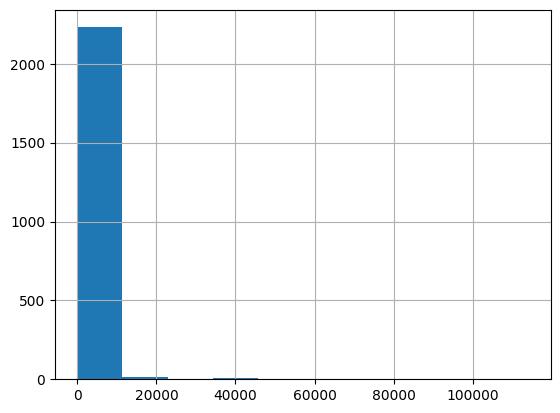

In [14]:
import tiktoken
tokenizer = tiktoken.get_encoding("cl100k_base")
df = pd.read_csv("processed/scraped3.csv", index_col= 0)
df.columns = ['text', 'id']
df = df[pd.notna(df['text'])]
df['no_tokens'] = df.text.apply(lambda x : len(tokenizer.encode(x)))
df['no_tokens'].hist()

In [15]:
#Just to save the emebddings on to the disk
import google.generativeai as genai
import pandas as pd
import numpy as np
import uuid

def embed_texts_in_batches(texts, batch_size=5, model="models/embedding-001"):
    embeddings_list = []
    texts = [str(text) for text in texts if not isinstance(text, float) or not np.isnan(text)]
    # Split texts into batches
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]
        embeddings_batch = embed_batch(batch_texts, model=model)
        embeddings_list.extend(embeddings_batch)

    return pd.DataFrame({"text": texts, "embedding": embeddings_list, "id" :[uuid.uuid4() for _ in range(len(texts))]})

def embed_batch(texts, model):
    return genai.embed_content(
            model=model,
            content=texts,
            task_type="retrieval_document"
        )['embedding']
  

texts = df['text'].tolist()
embeddings_df = embed_texts_in_batches(texts, batch_size=5)
embeddings_df.to_csv('processed/final1.csv', index=False)  
print(embeddings_df)

                                                   text  \
0     October 2024 UpdatePhysics Handbook GUIDELINES...   
1     Student Handbook 2021Student Handbook 2021 iCo...   
2     The Department of Chemistry Student Handbook L...   
3     Creative Writing Handbook 2024-251 CONTENTS 1....   
4     Computer Science Ashoka University   NEP Recom...   
...                                                 ...   
2250          The Biology UG handbook               ...   
2251  Student Handbook 2022Student Handbook 2022 iCo...   
2252  2 0 2 3 UNDERGRADUATE Student HandbookPreface ...   
2253  UNDERGRADUATE Student Handbook 2024Preface Wel...   
2254  1         DEPARTMENT OF VISUAL ARTS  HANDBOOK ...   

                                              embedding  \
0     [0.050963648, -0.018329807, -0.0032624514, -0....   
1     [0.07408372, -0.047968466, -0.032775424, 0.007...   
2     [0.071765445, 0.008037857, -0.028769512, -0.02...   
3     [0.060168613, -0.0663902, -0.025775827, -0.050...

In [19]:
#initialise the connection to the vector store, recreating the collection.
from qdrant_client import QdrantClient
client = QdrantClient(
    url=os.getenv('QDRANT_HOST'),
    api_key=os.getenv('QDRANT_API_KEY'),
)

# client.recreate_collection(
#     collection_name="University_assistant", 
#     vectors_config= VectorParams(size = 768, distance=Distance.DOT)
# )

if not client.collection_exists("University_assistant2"):
    client.create_collection(
        collection_name='University_assistant2', 
        vectors_config= VectorParams(size=768, distance= Distance.COSINE)
    )


print(client.collection_exists(collection_name='University_assistant2'))

INFO:httpx:HTTP Request: GET https://36f740cf-8ca2-456b-8653-dc6953576e5c.eu-west-2-0.aws.cloud.qdrant.io:6333 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://36f740cf-8ca2-456b-8653-dc6953576e5c.eu-west-2-0.aws.cloud.qdrant.io:6333/collections/University_assistant2/exists "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: PUT https://36f740cf-8ca2-456b-8653-dc6953576e5c.eu-west-2-0.aws.cloud.qdrant.io:6333/collections/University_assistant2 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://36f740cf-8ca2-456b-8653-dc6953576e5c.eu-west-2-0.aws.cloud.qdrant.io:6333/collections/University_assistant2/exists "HTTP/1.1 200 OK"


True


In [21]:
import ast
from itertools import islice

embeddings_df = pd.read_csv('processed/final1.csv')
embeddings_df['embedding'] = embeddings_df['embedding'].apply(ast.literal_eval)
embeddings_df.to_csv('processed/final1.csv')


def batched(iterable, n):
    iterator = iter(iterable)
    while batch := list(islice(iterator, n)):
        yield batch

batch_size = 100

for batch in batched(embeddings_df.to_dict('records'), batch_size):
    ids = [point["id"] for point in batch]
    vectors = [point["embedding"] for point in batch]
    payloads = [{"text": point["text"]} for point in batch]

    client.upsert(
        collection_name="University_assistant2",
        points=models.Batch(
            ids=ids,
            vectors=vectors,
            payloads=payloads,
        ),
    )

INFO:httpx:HTTP Request: PUT https://36f740cf-8ca2-456b-8653-dc6953576e5c.eu-west-2-0.aws.cloud.qdrant.io:6333/collections/University_assistant2/points?wait=true "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: PUT https://36f740cf-8ca2-456b-8653-dc6953576e5c.eu-west-2-0.aws.cloud.qdrant.io:6333/collections/University_assistant2/points?wait=true "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: PUT https://36f740cf-8ca2-456b-8653-dc6953576e5c.eu-west-2-0.aws.cloud.qdrant.io:6333/collections/University_assistant2/points?wait=true "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: PUT https://36f740cf-8ca2-456b-8653-dc6953576e5c.eu-west-2-0.aws.cloud.qdrant.io:6333/collections/University_assistant2/points?wait=true "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: PUT https://36f740cf-8ca2-456b-8653-dc6953576e5c.eu-west-2-0.aws.cloud.qdrant.io:6333/collections/University_assistant2/points?wait=true "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: PUT https://36f740cf-8ca2-456b-8653-dc6953576e5c.eu-west-2-0.aws.cloud.qdra

In [ ]:
from typing import List, Any
import google.generativeai as genai
'''Implementation from scratch for a simple RAG model, without using langchain'''

client = QdrantClient(
    url=os.getenv('QDRANT_HOST'),
    api_key=os.getenv('QDRANT_API_KEY'),
)


class GenerateAnswer:
    def __init__(self, ai_model: str, embedding_model: str, client: Any, collection_name: str):
        self.model = ai_model
        self.embedding_model = embedding_model
        self.client = client
        self.collection_name = collection_name

    def embedQuery(self, query: str) -> List[float]:
        """Embed the given query."""
        try:
            embeddedQuery = genai.embed_content(
                model=self.embedding_model,
                content=query,
                task_type="retrieval_query",
            )
            return embeddedQuery['embedding']
        except Exception as e:
            print(f"Error in embedding query: {e}")
            return []

    def similaritySearch(self, query: str, score_threshold: float, limit: int = 10) -> List[str]:
        """Perform similarity search based on the embedded query."""
        try:
            embedded_query = self.embedQuery(query)
            hits = self.client.search(
                collection_name=self.collection_name,
                query_vector=embedded_query,
                limit=limit,
                score_threshold=score_threshold,
            )
            # Extract page_content from each hit
            page_contents = [hit.payload['text'] for hit in hits if hit.payload and 'text' in hit.payload]
            
            return page_contents
        except Exception as e:
            print(f"Error in similarity search: {e}")
            return []
    def history():
        pass
    
    def promptTemplate(self, query: str) -> str:
        """Generate a prompt template with context."""
        context_list = self.similaritySearch(query, score_threshold=0.3)  # You might want to make this threshold configurable
        context = "\n".join(context_list)  # Join all context items into a single string
        template = f"""
        You are a helpful AI assistant for ashoka university students.
        Answer based on the context provided.
        Context: {context}
        Input: {query}
        Answer:
        """
        return template

    def cookAnswer(self, query: str) -> str:
        """Generate an answer based on the query."""
        try:
            model = genai.GenerativeModel(self.model)
            result = model.generate_content(self.promptTemplate(query))
            return result.text
        except Exception as e:
            print(f"Error in generating answer: {e}")
            return "Sorry, I couldn't generate an answer at this time."               

INFO:httpx:HTTP Request: GET https://36f740cf-8ca2-456b-8653-dc6953576e5c.eu-west-2-0.aws.cloud.qdrant.io:6333 "HTTP/1.1 200 OK"


In [27]:
# Initialize the class
answer_generator = GenerateAnswer(
    ai_model= 	"models/gemini-1.5-flash",
    embedding_model="models/embedding-001",
    client=client,
    collection_name="University_assistant2"
)

query = "tell me about the entrepreneur department handbook"
hits = answer_generator.similaritySearch(query, score_threshold=0.5)
template = answer_generator.promptTemplate(query)
results = answer_generator.cookAnswer(query)
print(hits)
print(results)

C:\Users\NITRO\AppData\Local\Temp\ipykernel_15664\103225483.py:35: DeprecationWarning: `search` method is deprecated and will be removed in the future. Use `query_points` instead.
  hits = self.client.search(
INFO:httpx:HTTP Request: POST https://36f740cf-8ca2-456b-8653-dc6953576e5c.eu-west-2-0.aws.cloud.qdrant.io:6333/collections/University_assistant2/points/search "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://36f740cf-8ca2-456b-8653-dc6953576e5c.eu-west-2-0.aws.cloud.qdrant.io:6333/collections/University_assistant2/points/search "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://36f740cf-8ca2-456b-8653-dc6953576e5c.eu-west-2-0.aws.cloud.qdrant.io:6333/collections/University_assistant2/points/search "HTTP/1.1 200 OK"


['Entrepreneurial Leadership and Strategy Handbook & Student Guide 1 Table of Contents I. Introduction 3 II. Faculty 4 III. Academic Programs 6 ● Minor in Entrepreneurship ● Concentration in Entrepreneurship ● Interdisciplinary Major IV. Pre-requistes and other credit options 7-9 V. Overview 10-13 VI. Courses offered - Spring 2025 14-35 VII. FAQs and Contact information 36-37 2 About InfoEdge Centre for Entrepreneurship The InfoEdge Centre for Entrepreneurship at Ashoka University is known for blending Liberal Arts and Sciences with Entrepreneurship. The Centre offers a unique interdisciplinary approach to learning and creating positive social impact. The Department offers an Interdisciplinary major with Computer Science, a Minor and a Concentration in Entrepreneurial Leadership and Strategy . To achieve the goal of driving meaningful change, the Centre provides a range of academic interventions, as well as incubation and acceleration programs, while also offering access to valuable re

university_assistant - working
university_assistant1 - not working
university_assistant2 - working (current use)
university_lassistant - working langchain (university_assistant)
university_lassistant - working langchain(university_assistant2)

In [28]:
from qdrant_client import QdrantClient
client = QdrantClient(
    url=os.getenv('QDRANT_HOST'),
    api_key=os.getenv('QDRANT_API_KEY'),
)

client.recreate_collection(
    collection_name= 'University_lassistant2', vectors_config= VectorParams(size = 768, distance= Distance.COSINE)
)

embeddings = GoogleGenerativeAIEmbeddings(model='models/embedding-001', google_api_key= os.getenv('GOOGLE_API_KEY'), task_type='retrieval_document')
vector_store = Qdrant(client=client, collection_name='University_lassistant2',embeddings=embeddings,)
vector_store.add_texts(df['text'])

INFO:httpx:HTTP Request: GET https://36f740cf-8ca2-456b-8653-dc6953576e5c.eu-west-2-0.aws.cloud.qdrant.io:6333 "HTTP/1.1 200 OK"
C:\Users\NITRO\AppData\Local\Temp\ipykernel_15664\756956560.py:7: DeprecationWarning: `recreate_collection` method is deprecated and will be removed in the future. Use `collection_exists` to check collection existence and `create_collection` instead.
  client.recreate_collection(
INFO:httpx:HTTP Request: DELETE https://36f740cf-8ca2-456b-8653-dc6953576e5c.eu-west-2-0.aws.cloud.qdrant.io:6333/collections/University_lassistant2 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: PUT https://36f740cf-8ca2-456b-8653-dc6953576e5c.eu-west-2-0.aws.cloud.qdrant.io:6333/collections/University_lassistant2 "HTTP/1.1 200 OK"
C:\Users\NITRO\AppData\Local\Temp\ipykernel_15664\756956560.py:12: LangChainDeprecationWarning: The class `Qdrant` was deprecated in LangChain 0.0.37 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-qdrant package a

['087f2950dcc74c049a7e30bb68731826',
 '2e7ec923bfad4e4a88ce7119ea48388e',
 'baf8bd44555d4c1cb7ea507f52d74414',
 '916131b0b06f442e96dd50ce9d4ff6e4',
 '0c1d9ec7f3e1453ab6183cca3963eba0',
 '0d492acf490444b9bac834b6fe96c527',
 '2808ef929949432bb6080a7525e432da',
 'e19e377b53184c128a223be844e3176d',
 '654998e61a7e4bed82189eb20a5503ee',
 'ff400d818a1a44159783292c4515d3c3',
 '28d400ac03aa456aa353654bca107916',
 'db052373f3b74cafa53e03ddb7770edc',
 '4817a02021384b1088a20e8206be13e7',
 'f16126315b954f7180cdc68329b4e216',
 'f921328aef6345fe88d8c24adafd9981',
 '029df1d955a8495d9c223dfee159cf55',
 'a6b2031141a64adca15818446fd39029',
 'e043cdc6f4694e3192c2be022c7dddda',
 '1ab6b19f700b4532a38a6047f9bb7868',
 '0a84c2f91de94777836069df20661231',
 '862a8bc78a7a4620902befff0dc837b1',
 '1e168b3832e54090a61360dec3c24cdd',
 '63c4dbe4bd944943bad491273145f85a',
 'c11a975808484c67a029568506b49f3f',
 '867310c128c145349a7718313649682c',
 'edbe909f457548bdb927e8ad8bc36870',
 'fb54eb59707649a79e4e65c7c0512906',
 

In [29]:
#Working the vector store to asses the retrievals
client = QdrantClient(
    url=os.getenv('QDRANT_HOST'),
    api_key=os.getenv('QDRANT_API_KEY'),
)

embeddings = GoogleGenerativeAIEmbeddings(model='models/embedding-001', google_api_key= os.getenv('GOOGLE_API_KEY'), task_type='retrieval_query')
doc_store = Qdrant(client=client, 
                   collection_name='University_lassistant2',
                   embeddings= embeddings)
#Examples
hits = client.search(
	collection_name="University_lassistant2",
	query_vector=embeddings.embed_query("computer science department handbook"),
	limit=2
)
for hit in hits:
	print(hit.payload, "score:", hit.score)

INFO:httpx:HTTP Request: GET https://36f740cf-8ca2-456b-8653-dc6953576e5c.eu-west-2-0.aws.cloud.qdrant.io:6333 "HTTP/1.1 200 OK"
C:\Users\NITRO\AppData\Local\Temp\ipykernel_15664\1190678336.py:12: DeprecationWarning: `search` method is deprecated and will be removed in the future. Use `query_points` instead.
  hits = client.search(
INFO:httpx:HTTP Request: POST https://36f740cf-8ca2-456b-8653-dc6953576e5c.eu-west-2-0.aws.cloud.qdrant.io:6333/collections/University_lassistant2/points/search "HTTP/1.1 200 OK"


{'page_content': "--- title: Department of Computer Science sitename: Ashoka University: Leading Liberal Arts and Sciences University date: 2025-03-25 tags: ['Ashoka News'] --- The Department of Computer Science at Ashoka University fosters a research-driven approach to both foundational and applied areas of computing. Its unique positioning within a liberal arts environment provides a distinctive opportunity to advance core computer science research while also exploring interdisciplinary applications across the natural and social sciences. Our department values the cross-pollination of ideas from diverse fields, not only to solve existing problems but to ask novel research questions that deepen and expand the scope of computer science. Through this integration of foundational knowledge and interdisciplinary engagement, Ashoka’s CS department contributes meaningfully to both the theoretical and societal dimensions of the field. The center leverages Ashoka’s interdisciplinary strengths 

In [30]:
from langchain.chains import create_retrieval_chain
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain_core.prompts import ChatPromptTemplate
from langchain_google_genai import GoogleGenerativeAI

retriever = doc_store.as_retriever(search_kwargs = {"k": 5})
llm = GoogleGenerativeAI(model='models/gemini-2.0-flash-exp', google_api_key=os.getenv('GOOGLE_API_KEY'))

template = """
you are a helpful ai assistant.
answer based on the context provided.you need not look for the exact similarity from the context.
context: {context}
input: {input}
answer:
"""
prompt = PromptTemplate.from_template(template)
combine_docs_chain = create_stuff_documents_chain(llm, prompt)
retrieval_chain = create_retrieval_chain(retriever, combine_docs_chain)
response = retrieval_chain.invoke({"input": "I am a second year first sem student, wanting to explore major in computer science, what courses should I take this semester?"})
print(response["answer"])


INFO:httpx:HTTP Request: POST https://36f740cf-8ca2-456b-8653-dc6953576e5c.eu-west-2-0.aws.cloud.qdrant.io:6333/collections/University_lassistant2/points/search "HTTP/1.1 200 OK"


Based on the provided information, here are courses you can take this semester:

*   **Computer Organisation and Systems**
*   **Computer Networks (2 credits)**
*   **Information Security (2 credits)**
*   **Design Practices in CS**
*   **Introduction to Machine Learning**


In [2]:
def getSource():
    #add the metadata field to the database
        #to do this:
            #iterate through the directory, get the file names, process it and make it a link
            #add a column to the database calling metafield
            #now when retrieving the page content, retrieve the metadata as well, and return it along with the page content
    pass

def generateSimilarQ():
    #store the user query into a variable
        #now before the api call is made to generate the answer(which is done before querying the vector store)
        #query the google api to generate one or more questions similar to it
        #then pass in this extra question to the prompt template, then make the call to google API
    pass

def getEmail():
    #listen to gmail API, make a script which will run every 3 days, get the text of email, embed it
    #add to the data base
    pass